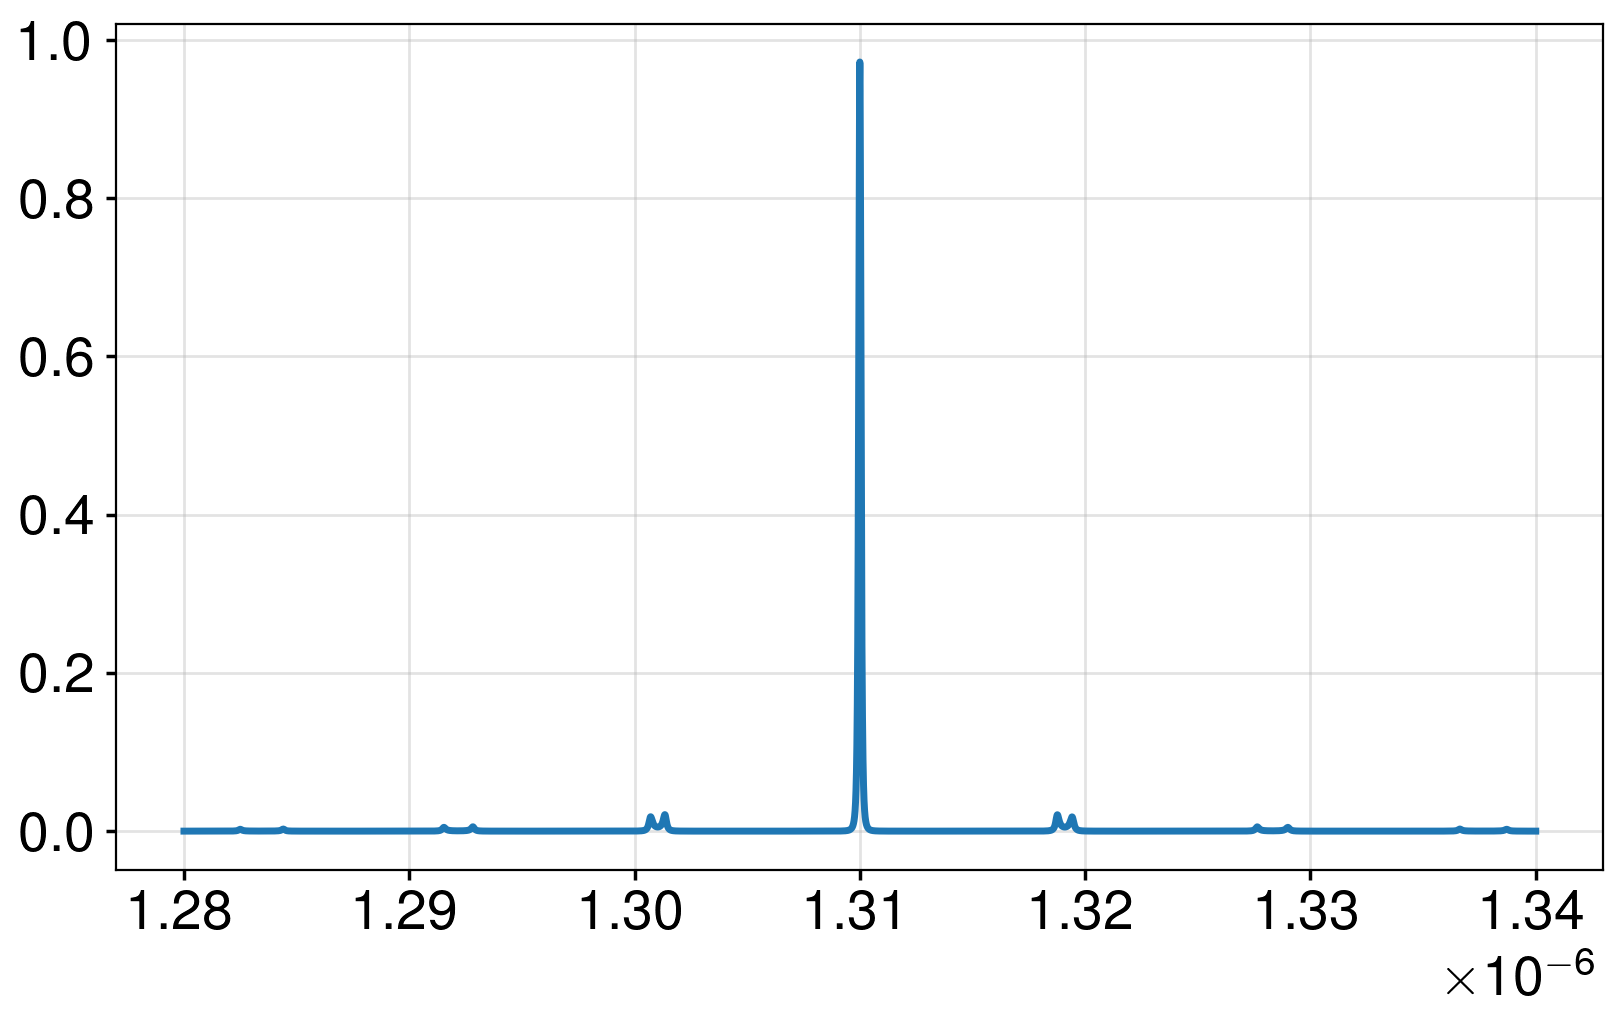

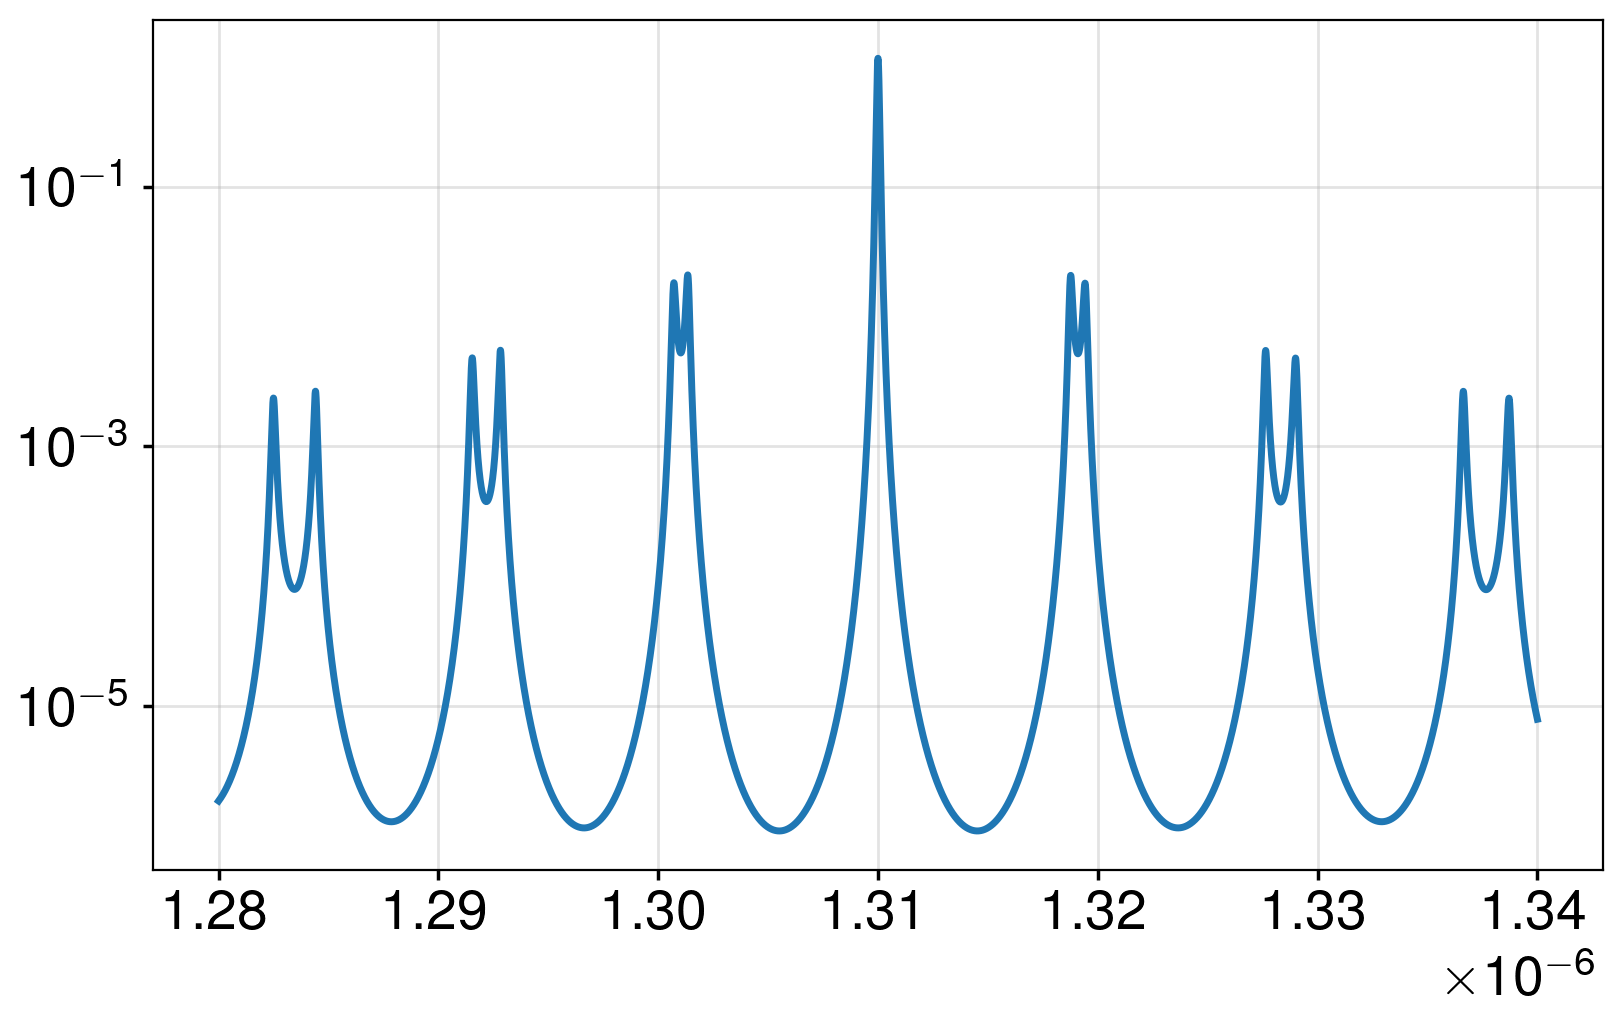

In [1]:
import numpy as np
import matplotlib.pyplot as plt
try:
    plt.style.use("/Users/asludds/Dropbox/mplstyle.mplstyle")
except:
    plt.style.use("../../mplstyle.mplstyle")
from scipy.optimize import newton
from tqdm import tqdm

import pandas as pd

vernier_transmission = pd.read_csv("Model_Data/vernier_transfer_function.csv").to_numpy()

vernier_wav = vernier_transmission[:,0]
vernier_amp = vernier_transmission[:,1]/1e-8

plt.figure()
plt.plot(vernier_wav,vernier_amp)
plt.show()

plt.figure()
plt.semilogy(vernier_wav,vernier_amp)
plt.show()

vernier_wav_1310nm_index = np.argmin(np.abs(vernier_wav - 1310e-9))
vernier_amp_closest_to_1310nm = vernier_amp[vernier_wav_1310nm_index]

In [2]:
# Import SOA model
from SOA_model import SOA

powers_to_check = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]

gain_storage = []
for P in powers_to_check:
    temp_gain_storage = []
    for Lambda in vernier_wav:
        soa = SOA(T=50,J=7,L=400,wl=Lambda*1e9)
        g = soa.gain(P)
        temp_gain_storage.append(g)

    gain_storage.append(temp_gain_storage)

gain_storage = np.array(gain_storage)

gain_at_1310nm = []
for P in powers_to_check:
    soa = SOA(T=50,J=7,L=400,wl=1310)
    g = soa.gain(P)
    gain_at_1310nm.append(g)

gain_at_1310nm = np.array(gain_at_1310nm)

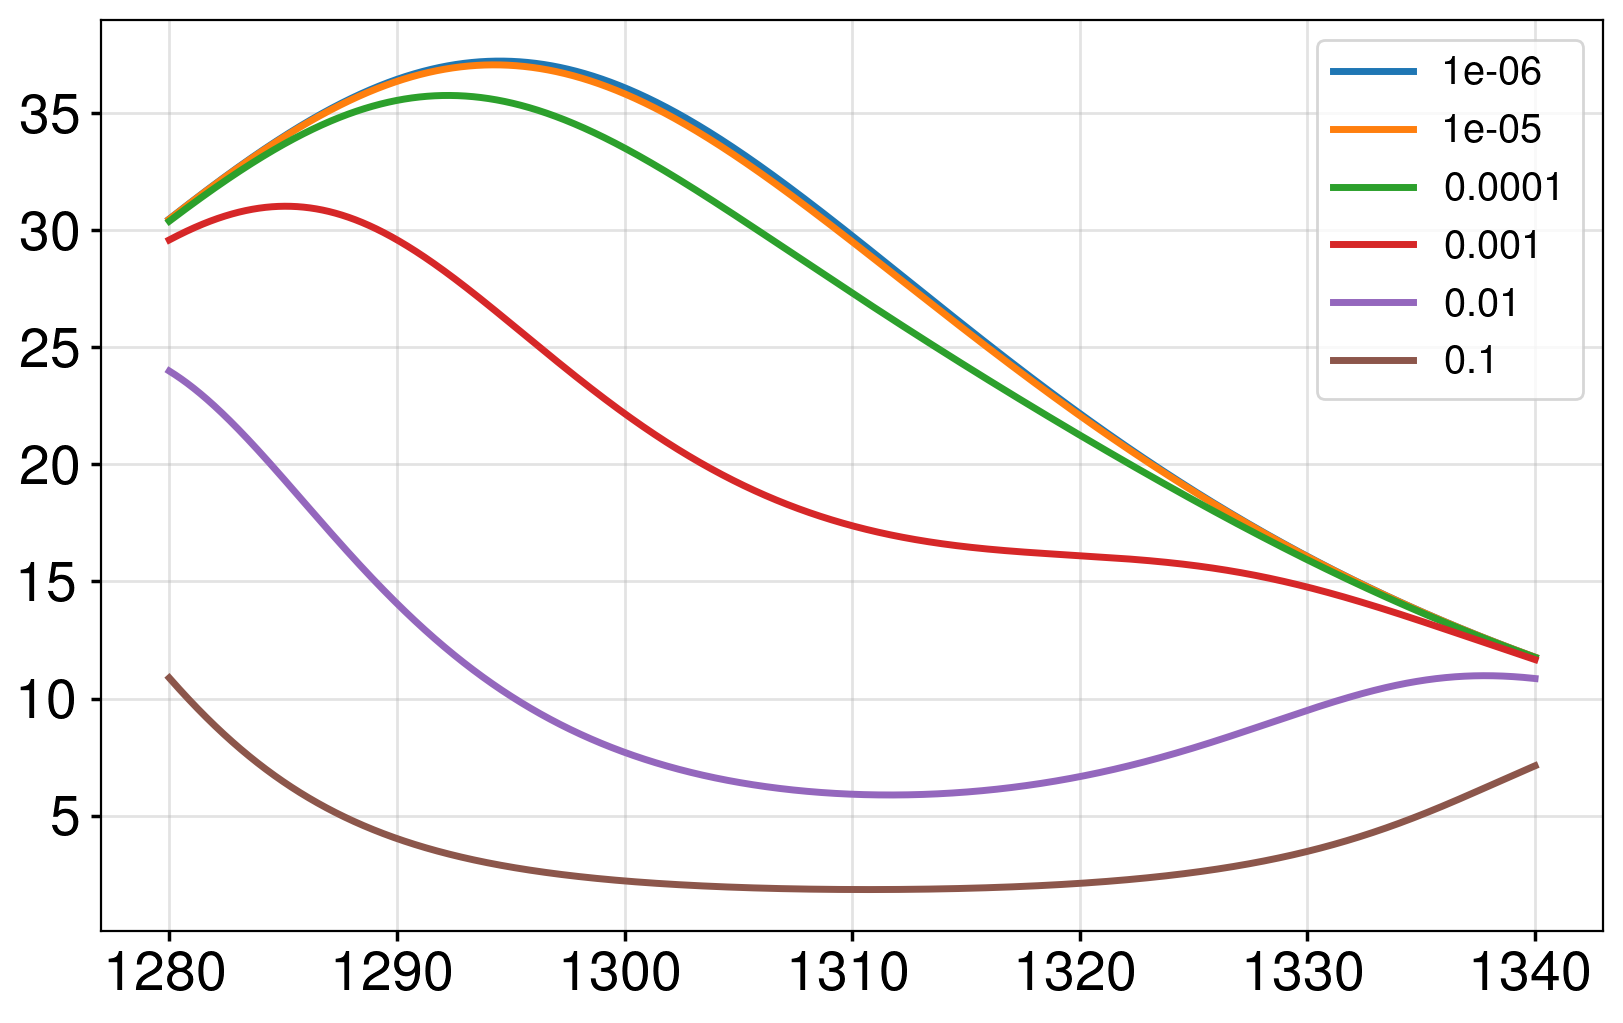

In [3]:
# print(gain_storage.shape)
plt.figure()
plt.plot(vernier_wav*1e9,gain_storage.T)
plt.legend(powers_to_check)

(60001,)
1.0289406366558296
[29.75622838 29.50639061 27.31453877 17.37802614  5.91426809  1.84545944]
[-28.72728775 -28.47744997 -26.28559813 -16.3490855   -4.88532745
  -0.81651881]


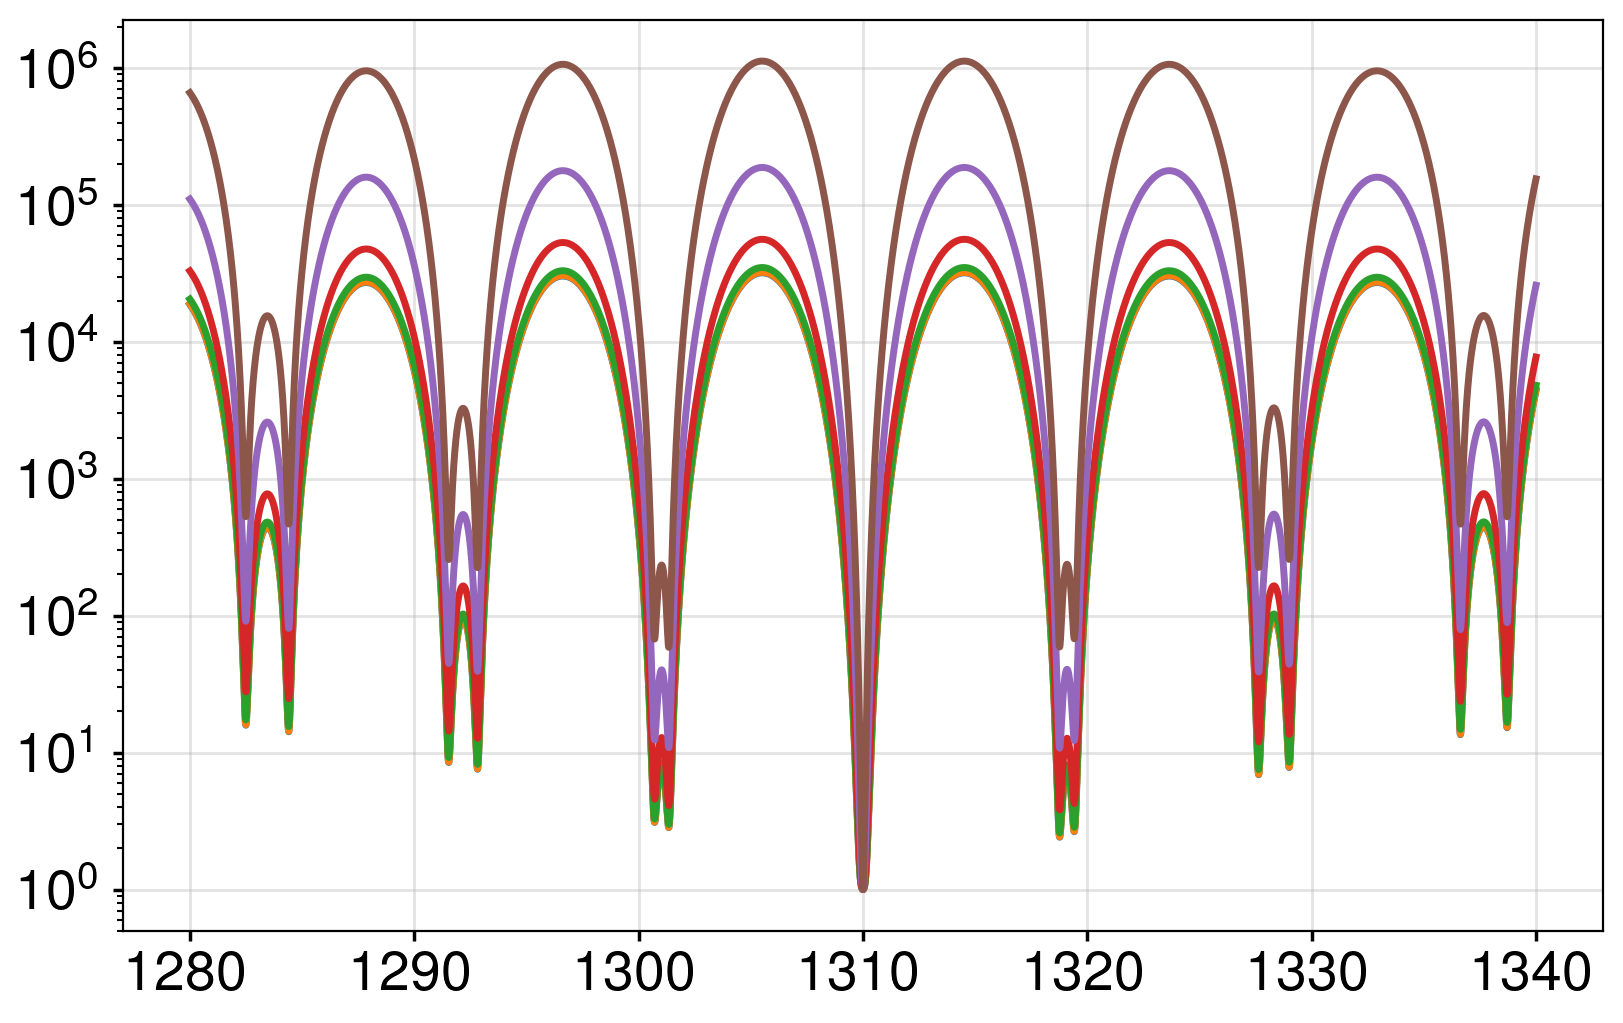

In [4]:
# Create a plot of MSR as a function of wavelength
deltaG = np.tile(gain_at_1310nm , (gain_storage.shape[1], 1)).T - gain_storage
deltaalpha = 1/vernier_amp_closest_to_1310nm - 1/vernier_amp
print(deltaalpha.shape)

main_mode_modal_gain = 1/vernier_amp_closest_to_1310nm - gain_at_1310nm
print(1/vernier_amp_closest_to_1310nm)
print(gain_at_1310nm)
print(main_mode_modal_gain)

MSR = (deltaalpha + deltaG)/np.tile(main_mode_modal_gain, (gain_storage.shape[1], 1)).T + 1

plt.figure()
plt.semilogy(vernier_wav*1e9,MSR.T)

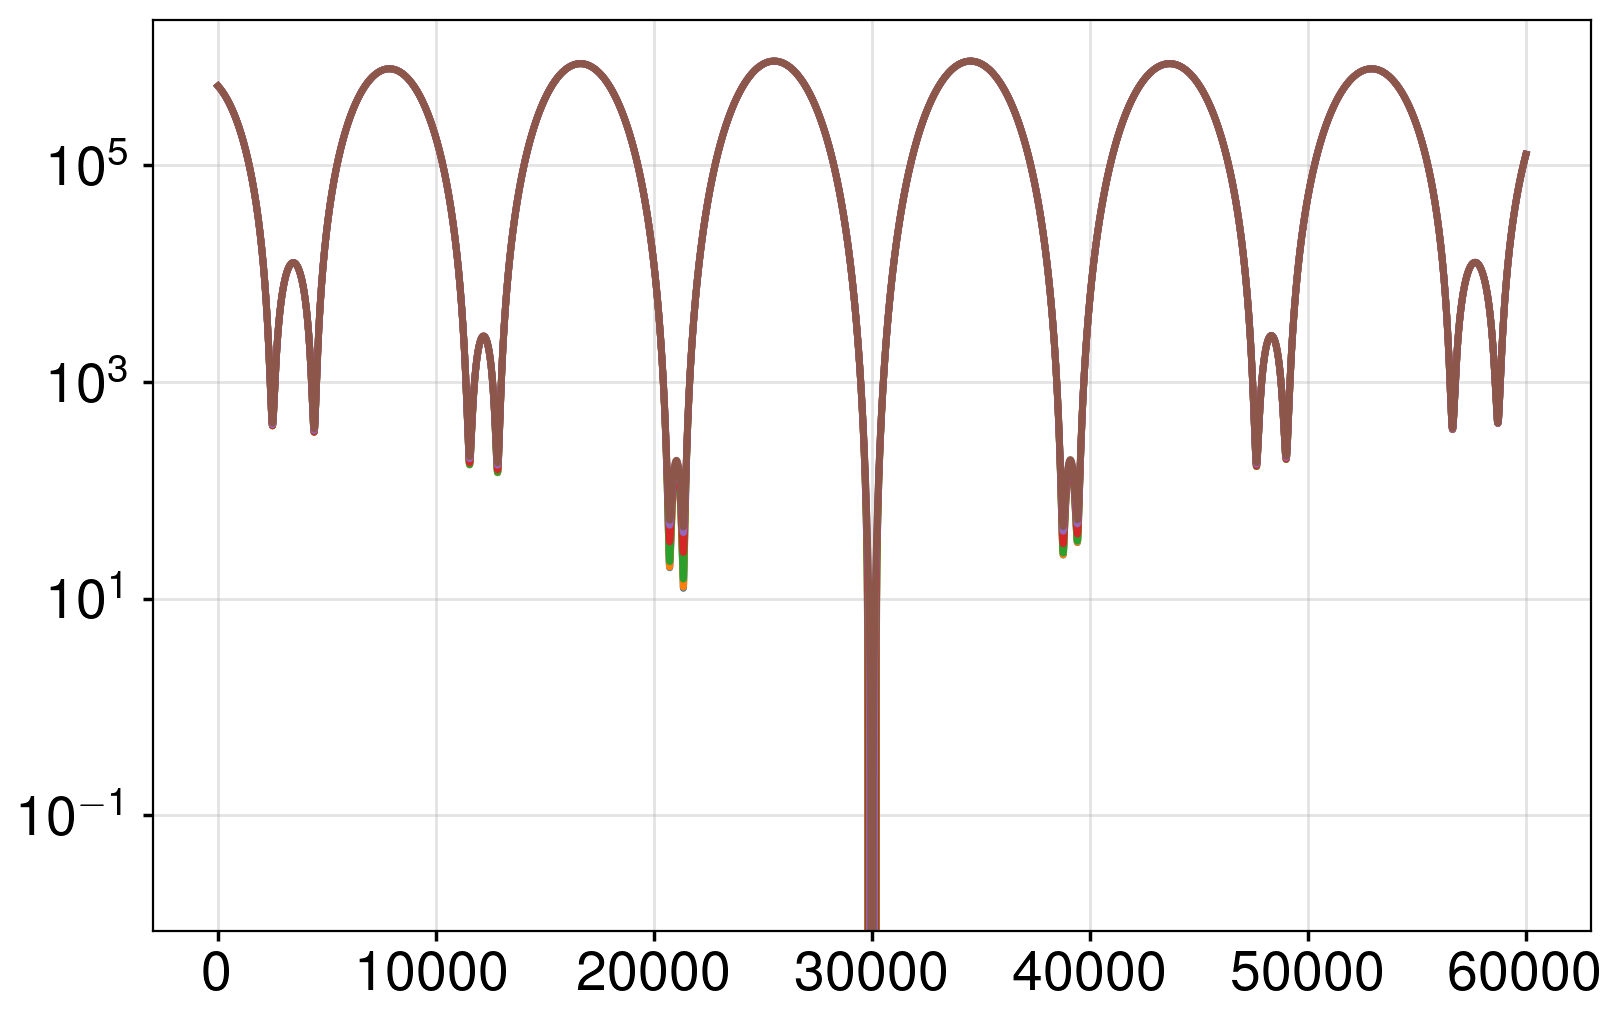

In [5]:
modal_loss = 1/vernier_amp
modal_gain = gain_storage

gain_minus_loss = modal_gain - modal_loss

plt.figure()
plt.semilogy(-gain_minus_loss.T)

(1309.5, 1310.5)

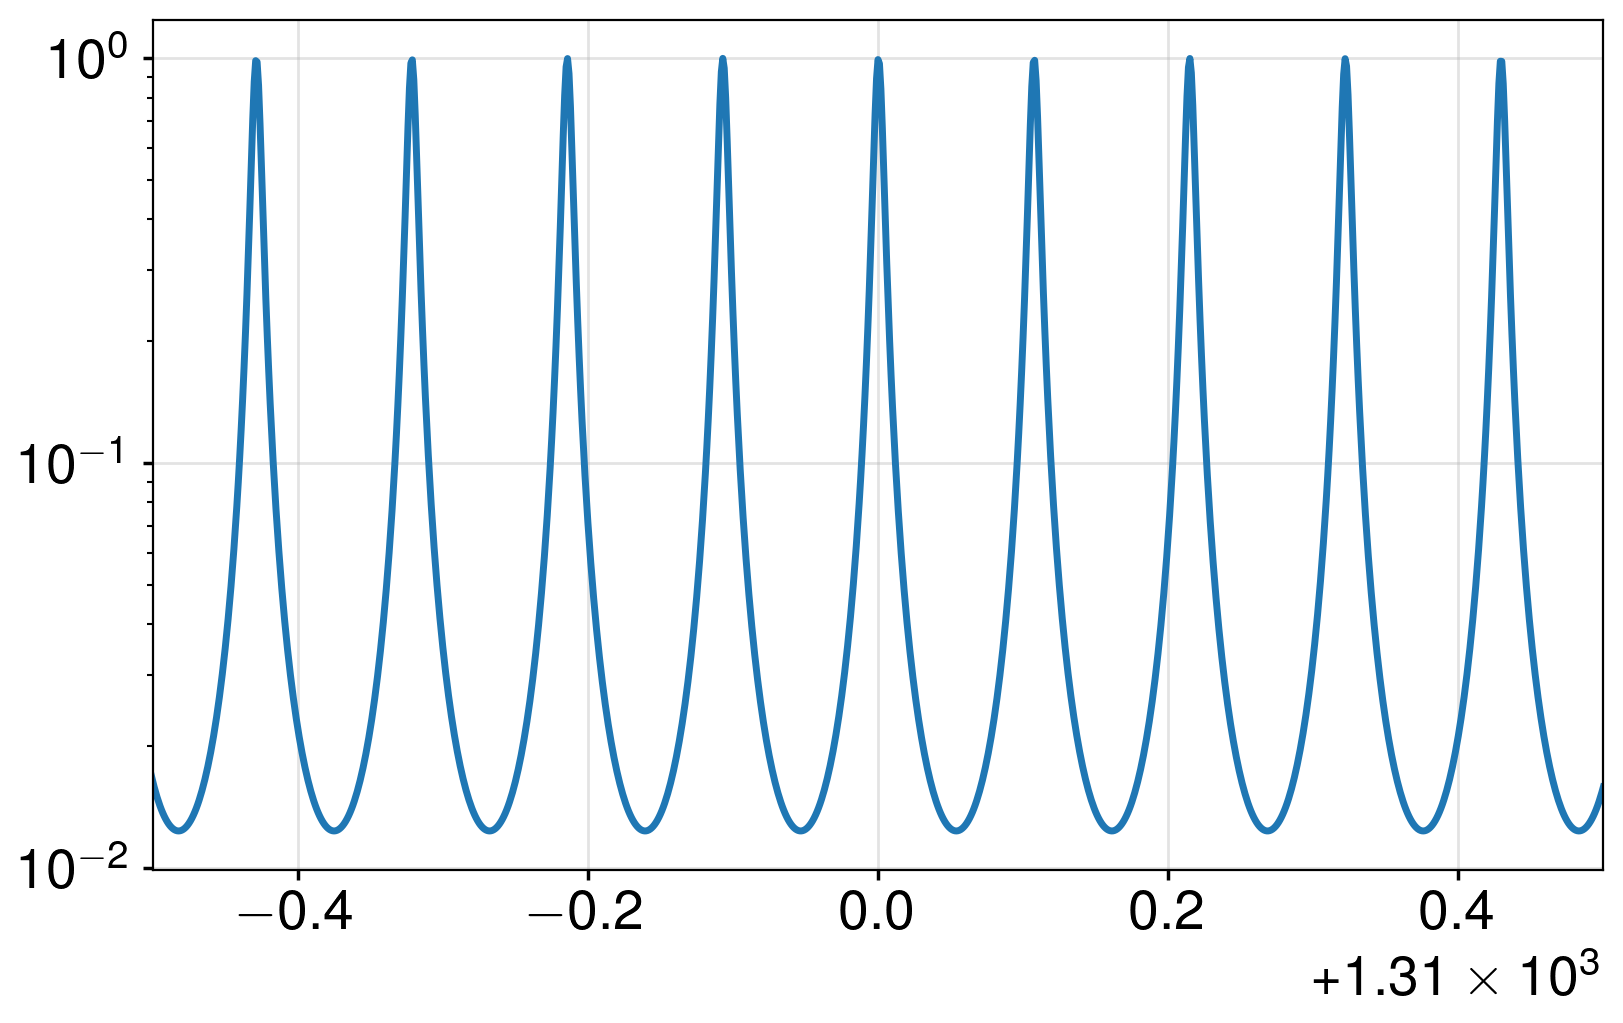

In [6]:
# Longitudinal cavity spectrum
def longitudinal_cavity_transmission(Lambda,R1,R2,n,L, internal_round_trip_loss=1,phi_offset = 0):
    # return 1/(1 + 4*R/(1-R)**2 * np.sin(2*np.pi/Lambda * n * L))
    T1 = 1 - R1
    T2 = 1 - R2
    num = np.sqrt(T1*T2) * internal_round_trip_loss *  np.exp(-1j * (2 * np.pi / Lambda * n * L + phi_offset))
    denom = 1 - np.sqrt(R1*R2) * np.exp(-2 * 1j * (2 * np.pi / Lambda * n * L + phi_offset))
    H = num/denom
    return np.real(H * np.conj(H))

L = 4e-3
n = 2
R = 0.8

tmp = np.array([longitudinal_cavity_transmission(i,R,R,n,L, phi_offset=0.825) for i in vernier_wav])

plt.figure()
plt.semilogy(vernier_wav*1e9,tmp)
plt.xlim(1309.5,1310.5)
# plt.ylim(0,1)

(1309.5, 1310.5)

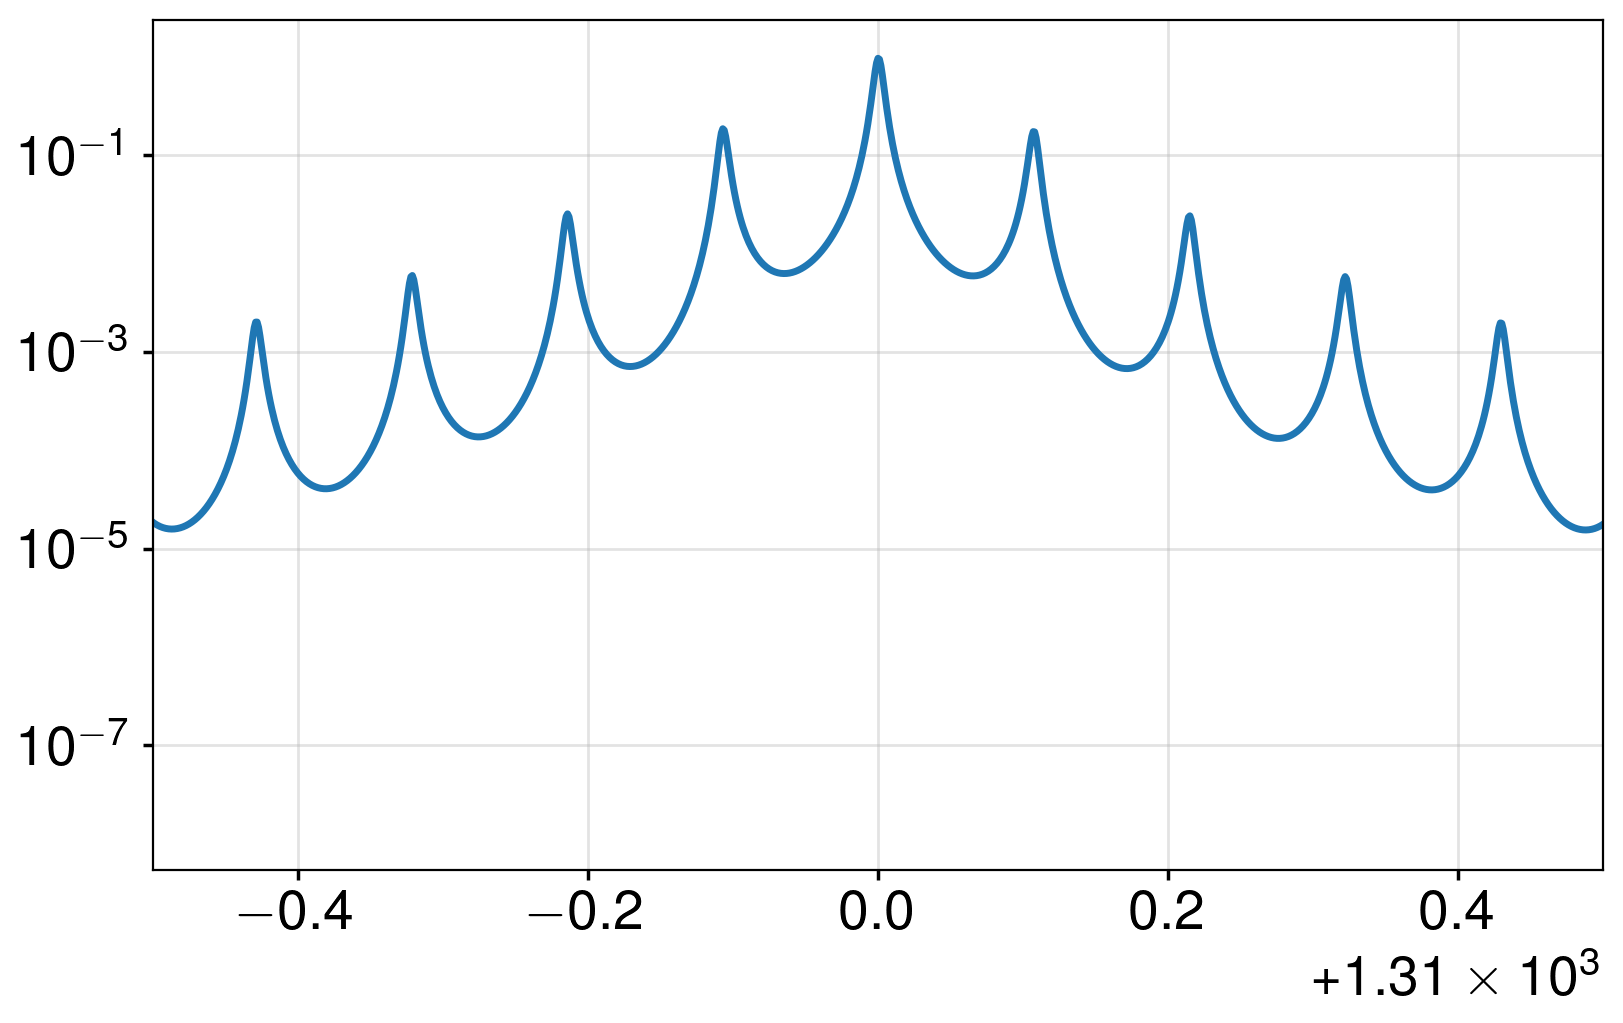

In [7]:
L = 4e-3
n = 2
R = 0.8

tmp = []
for i in range(len(vernier_amp)):
    tmp.append(vernier_amp[i] * longitudinal_cavity_transmission(vernier_wav[i],R,R,n,L, phi_offset=0.825))

long_and_vernier = np.array(tmp)

plt.figure()
plt.semilogy(vernier_wav*1e9,long_and_vernier)
plt.xlim(1309.5,1310.5)

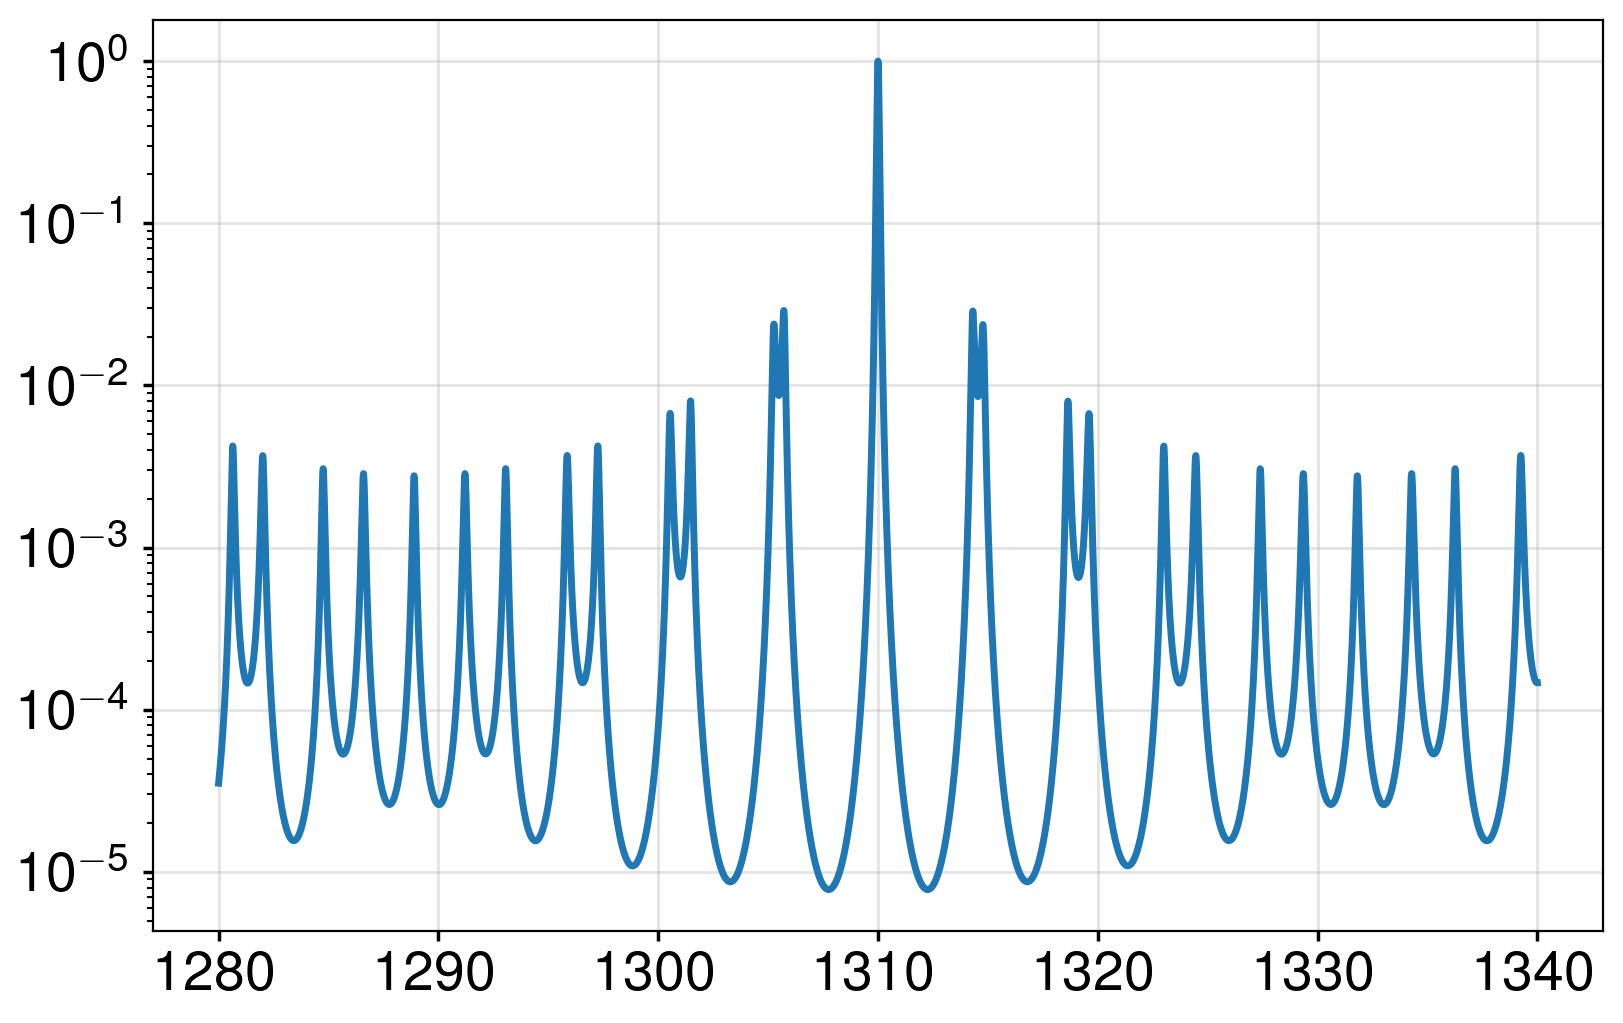

In [8]:
L = 100e-6
length_offset_fraction = 0.9
n = 2
R = 0.9

phi_sweep = np.linspace(-np.pi,np.pi,num=1000)
phi1 = phi_sweep[np.argmax([longitudinal_cavity_transmission(1310e-9,R,R,n,L, phi_offset=phi) for phi in phi_sweep])]
phi2 = phi_sweep[np.argmax([longitudinal_cavity_transmission(1310e-9,R,R,n,length_offset_fraction*L, phi_offset=phi) for phi in phi_sweep])]

synth_vernier_spectrum = np.array([longitudinal_cavity_transmission(i,R,R,n,L, phi_offset=phi1)*longitudinal_cavity_transmission(i,R,R,n,length_offset_fraction*L, phi_offset=phi2) for i in vernier_wav])

plt.figure()
plt.semilogy(vernier_wav*1e9,synth_vernier_spectrum)

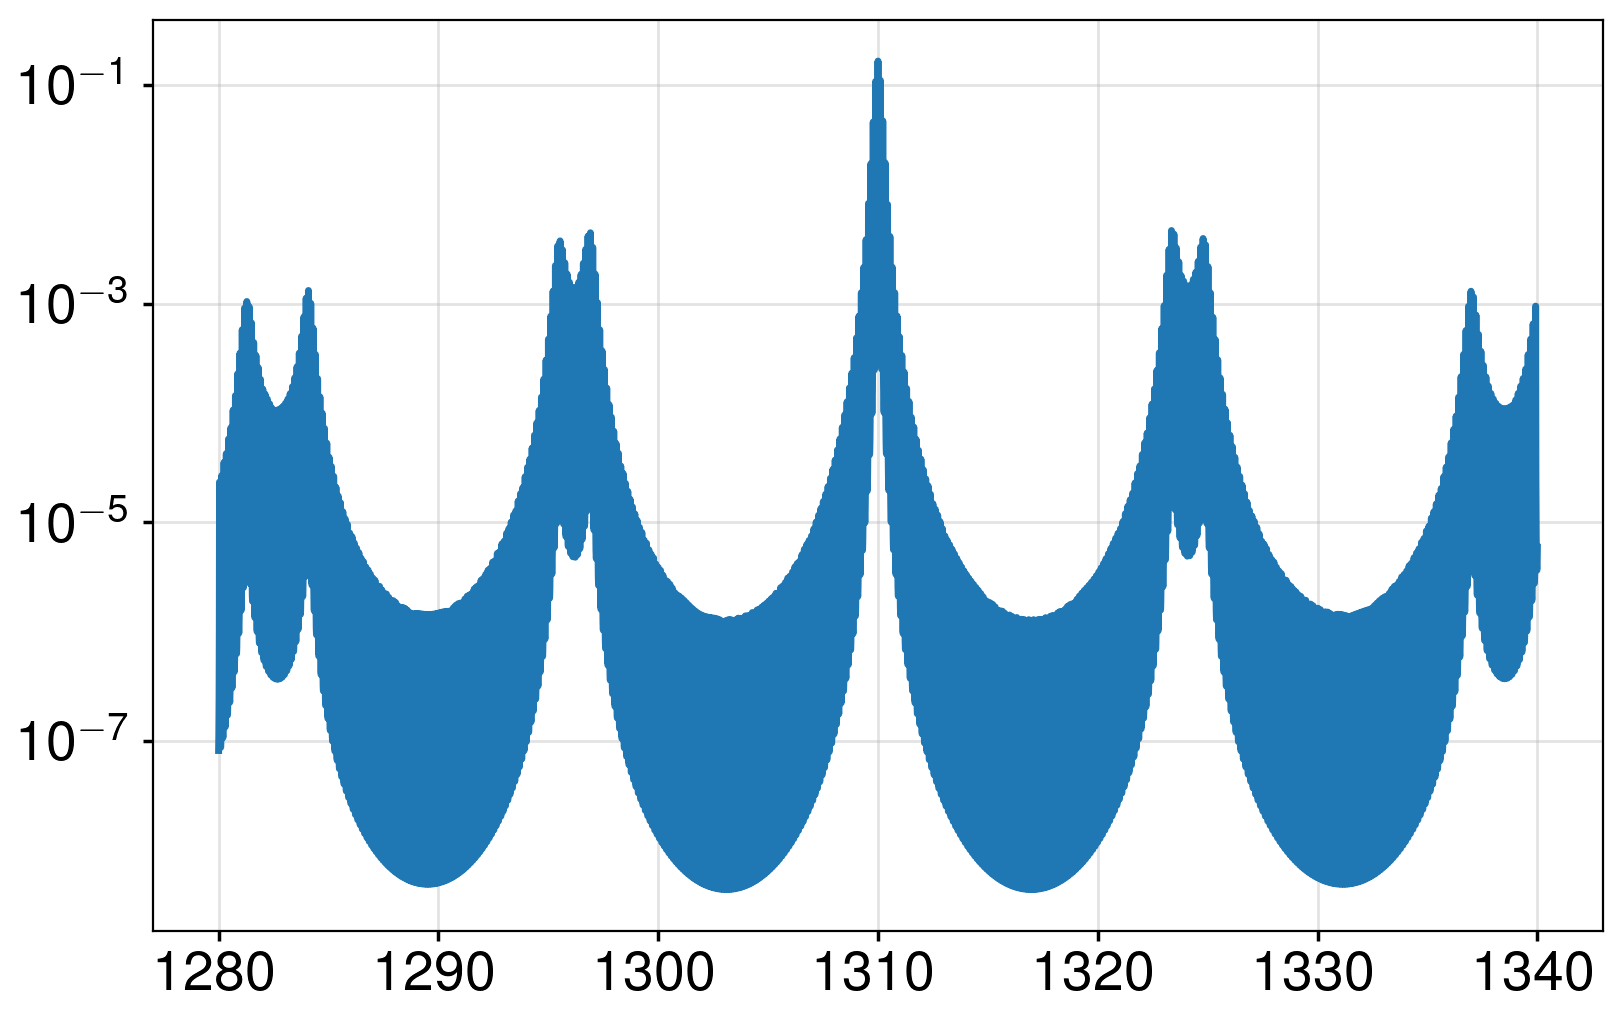

In [9]:
#Combine it all together
L = 2*np.pi*5.218*1e-6
L_long = 4e-3
length_offset_fraction = 0.9
n = 1.98
Pcouple_rings = 0.1
R = 0.8

phi_sweep = np.linspace(-np.pi,np.pi,num=2000)
phi1 = phi_sweep[np.argmax([longitudinal_cavity_transmission(1310e-9,1-Pcouple_rings,1-Pcouple_rings,n,L, phi_offset=phi) for phi in phi_sweep])]
phi2 = phi_sweep[np.argmax([longitudinal_cavity_transmission(1310e-9,1-Pcouple_rings,1-Pcouple_rings,n,length_offset_fraction*L, phi_offset=phi) for phi in phi_sweep])]
phi3 = phi_sweep[np.argmax([longitudinal_cavity_transmission(1310e-9,0.99,R,n,L_long, phi_offset=phi) for phi in phi_sweep])]

synth_vernier_with_longitudinal_mode_spectrum = np.array([longitudinal_cavity_transmission(i,1-Pcouple_rings,1-Pcouple_rings,n,L, phi_offset=phi1)*longitudinal_cavity_transmission(i,1-Pcouple_rings,1-Pcouple_rings,n,length_offset_fraction*L, phi_offset=phi2)*longitudinal_cavity_transmission(i,0.99,R,n,L_long, phi_offset=phi3) for i in vernier_wav])

loss_synth_vernier_with_longitudinal_mode_spectrum_1310 = longitudinal_cavity_transmission(1310e-9,1-Pcouple_rings,1-Pcouple_rings,n,L, phi_offset=phi1)*longitudinal_cavity_transmission(1310e-9,1-Pcouple_rings,1-Pcouple_rings,n,length_offset_fraction*L, phi_offset=phi2)*longitudinal_cavity_transmission(1310e-9,0.99,R,n,L_long, phi_offset=phi3)

plt.figure()
plt.semilogy(vernier_wav*1e9,synth_vernier_with_longitudinal_mode_spectrum)
# plt.xlim(1309.5,1310.5)

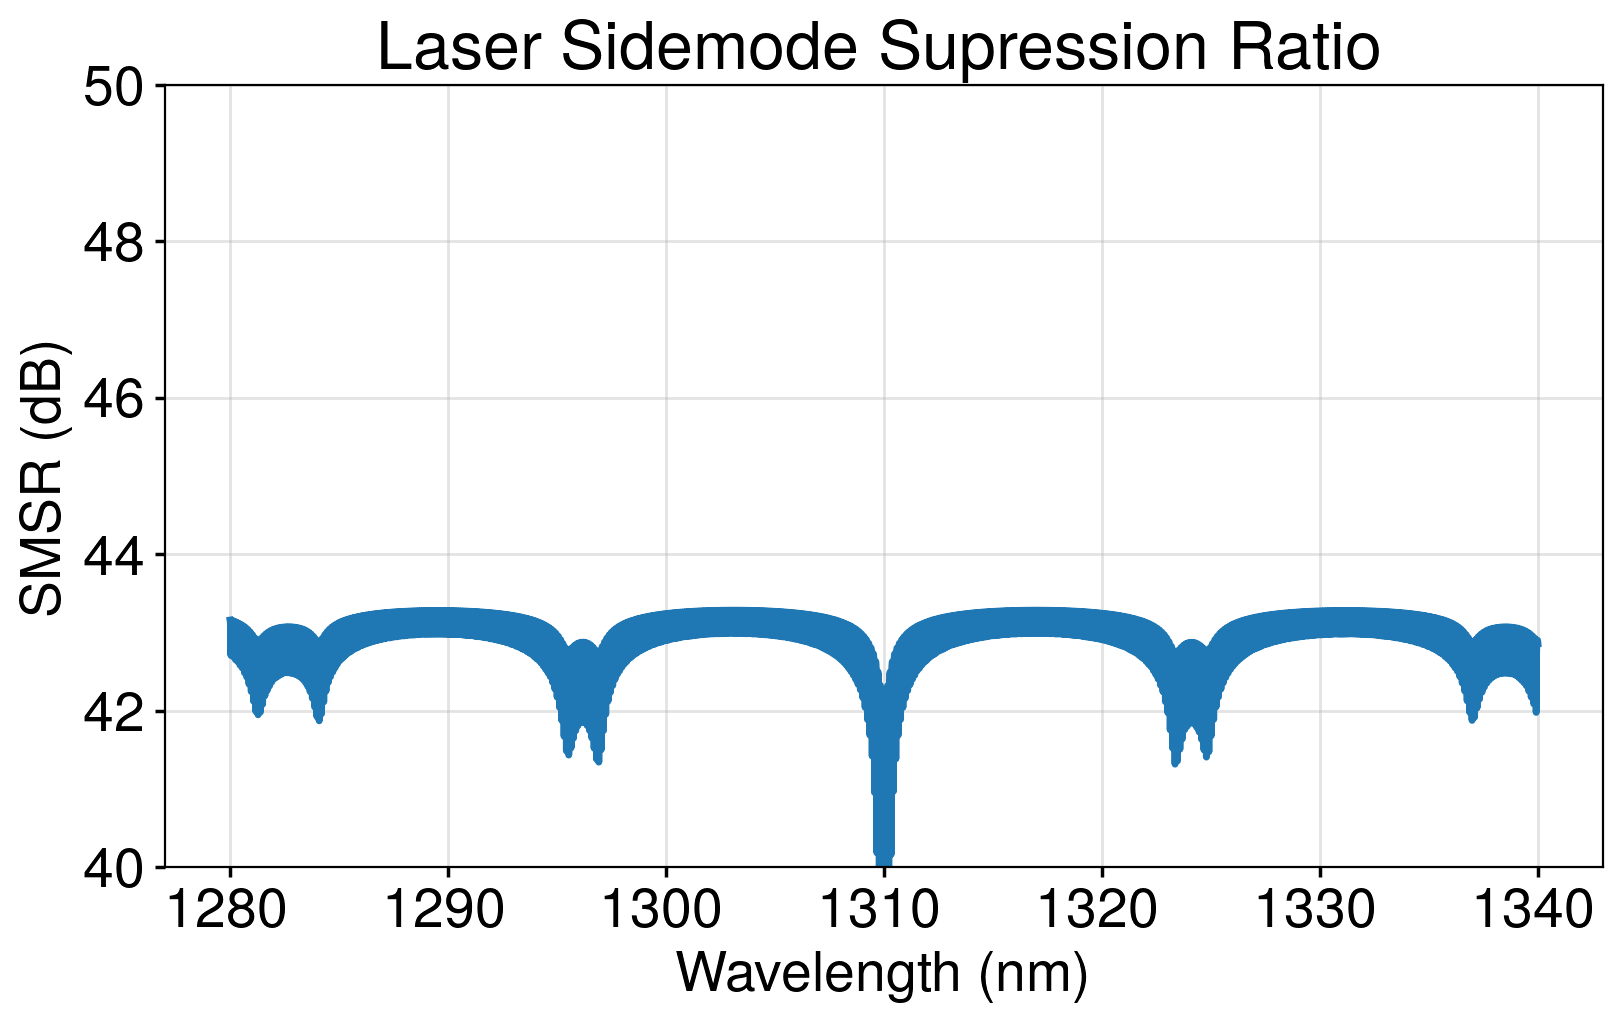

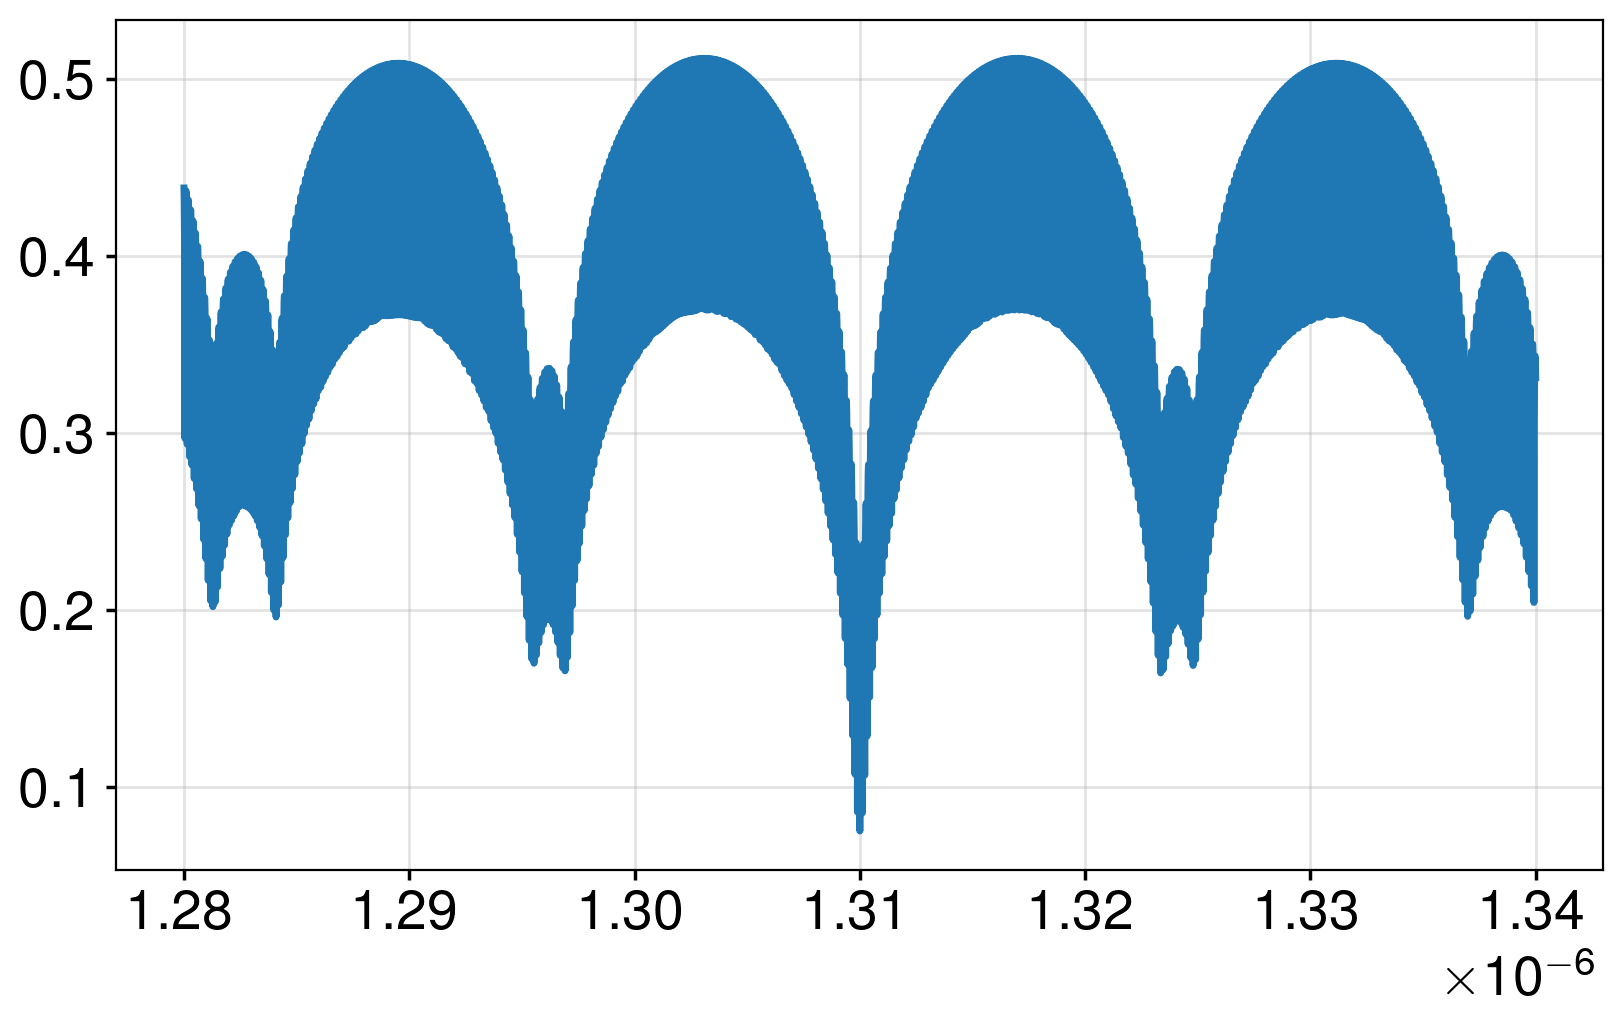

In [10]:
beta_SP = 1e-4
eta_R = 0.8
alphai = 760
Lsoa = 800e-6
Iratio = 3
alpham = 1/Lsoa * np.log(1/np.sqrt(synth_vernier_with_longitudinal_mode_spectrum))
deltaG = beta_SP*eta_R * (alphai + alpham)/(Iratio -1)
deltaalpha = 1/Lsoa * np.log(1/np.sqrt(synth_vernier_with_longitudinal_mode_spectrum/loss_synth_vernier_with_longitudinal_mode_spectrum_1310))

SMSR = 1 + deltaalpha/deltaG
SMSR_dB = 10*np.log10(SMSR)

plt.figure()
plt.plot(vernier_wav*1e9,SMSR_dB)
# plt.xlim(1309.5,1310.5)
plt.ylim(40,50)
plt.title("Laser Sidemode Supression Ratio")
plt.ylabel("SMSR (dB)")
plt.xlabel("Wavelength (nm)")
plt.show()

plt.figure()
plt.plot(vernier_wav,deltaG)

760


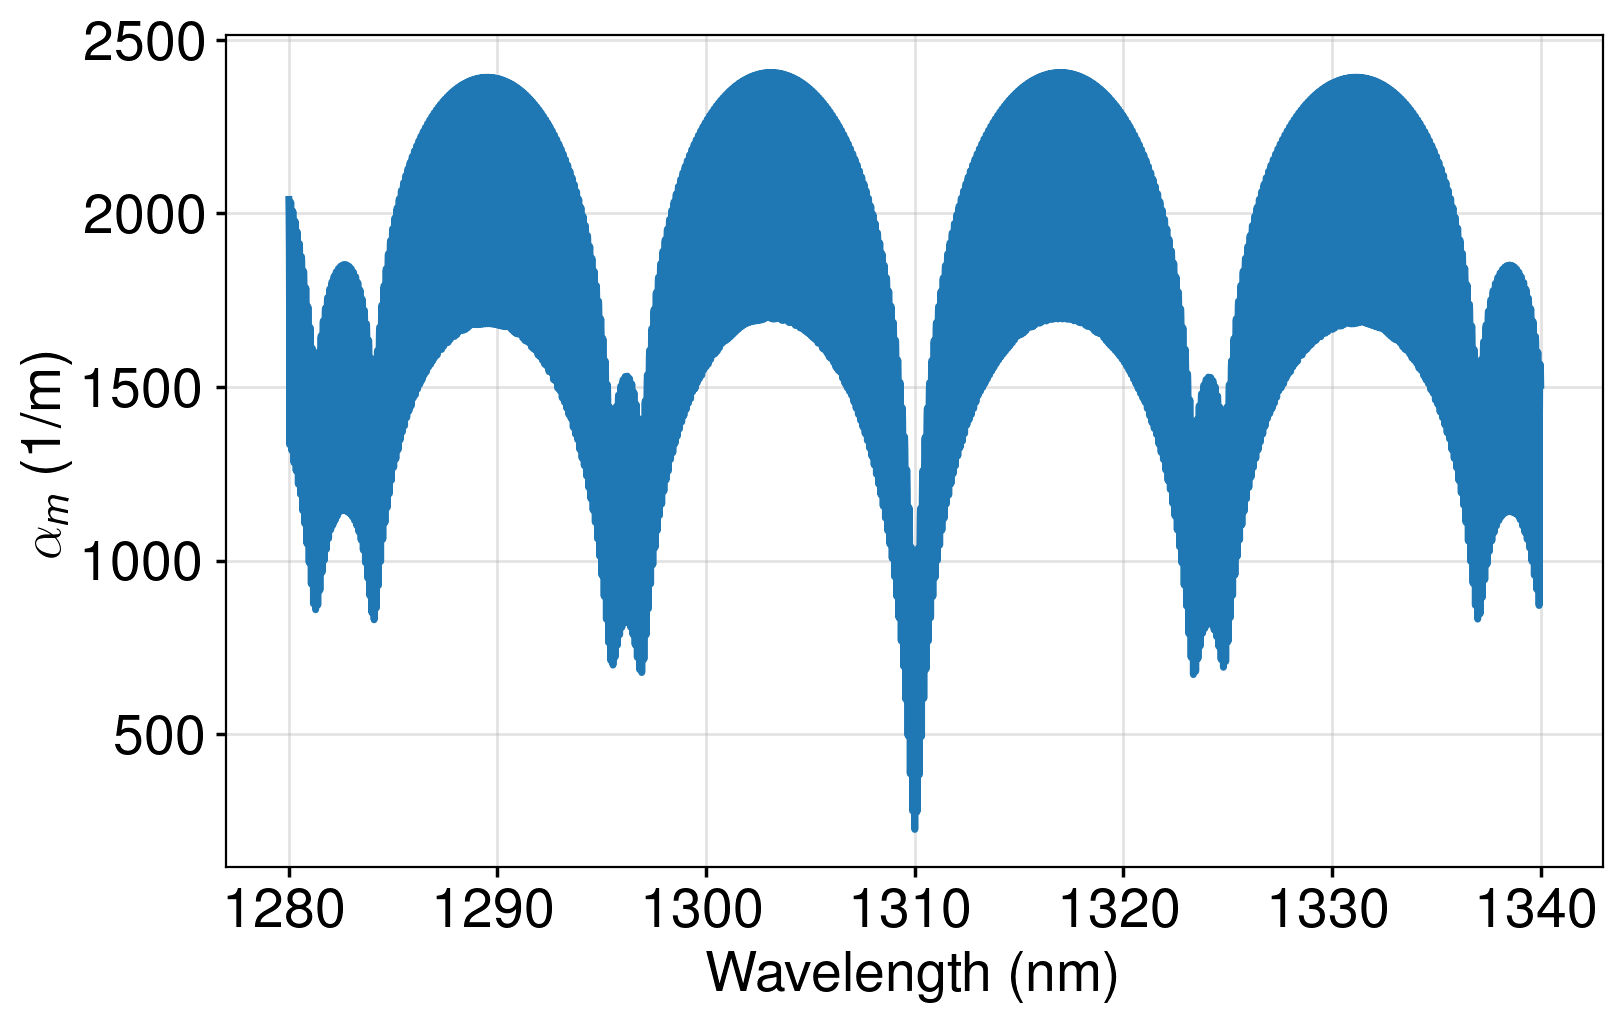

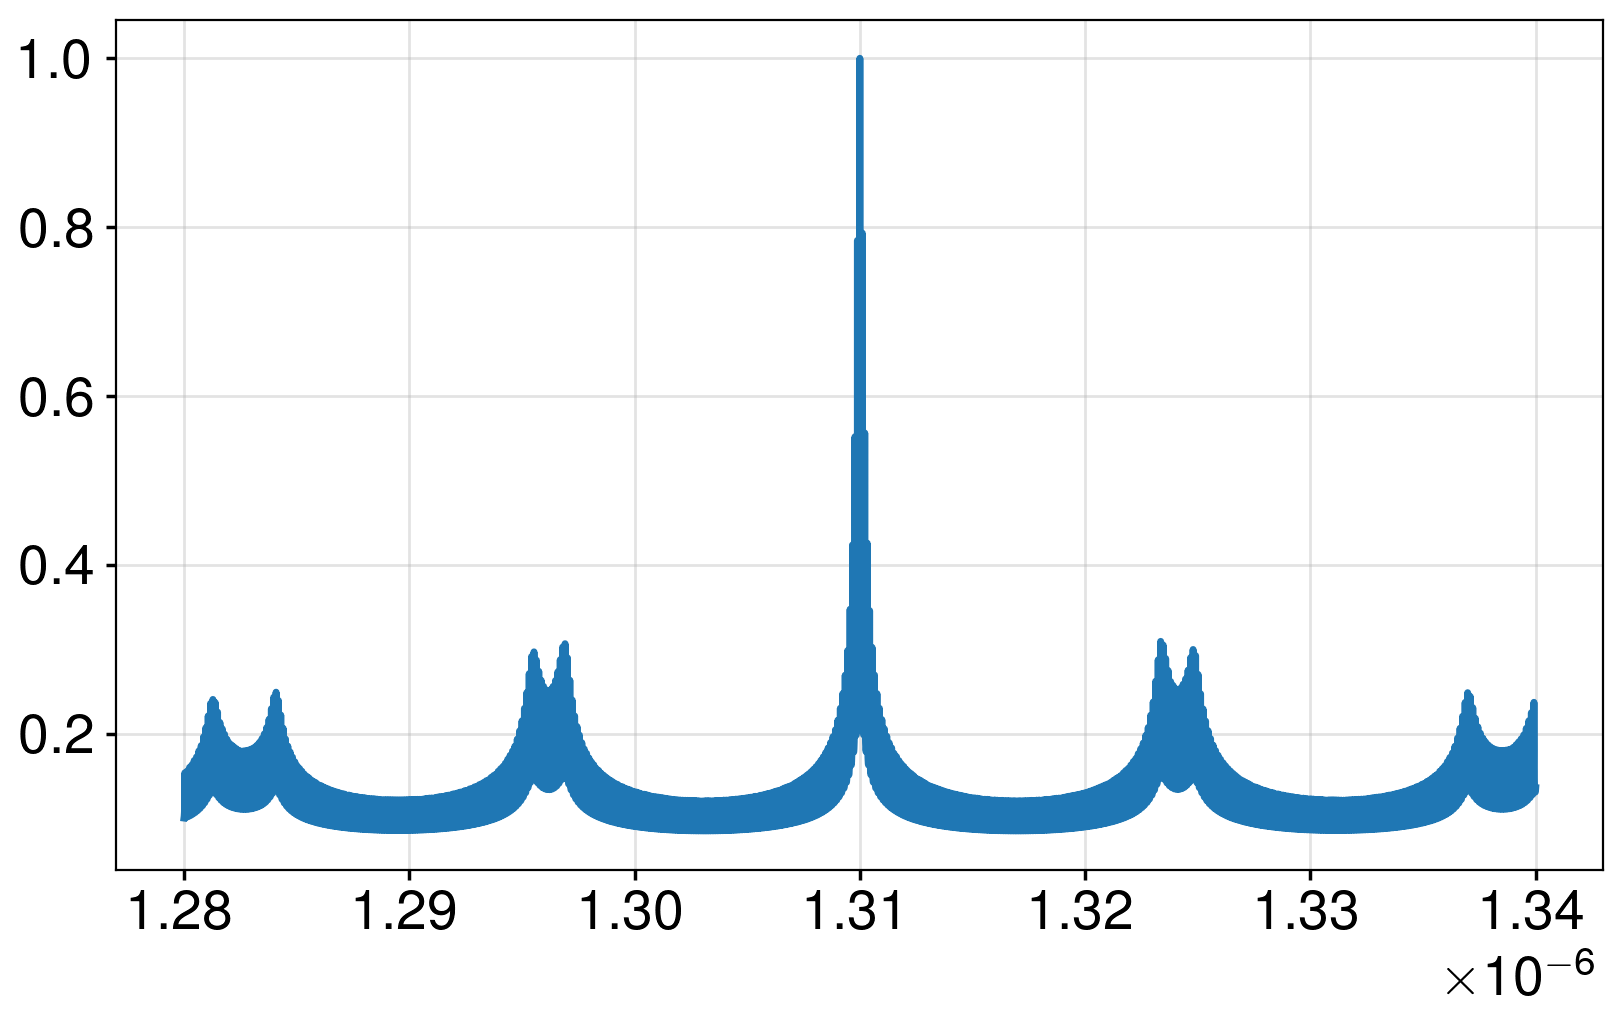

In [11]:
alpham = 1/L_long * np.log(1/np.sqrt(synth_vernier_with_longitudinal_mode_spectrum))
g = -np.log(synth_vernier_with_longitudinal_mode_spectrum)/Lsoa
# g = gain_storage[:,0]/L_long

print(alphai)

plt.figure()
plt.plot(vernier_wav*1e9,alpham)
plt.xlabel("Wavelength (nm)")
plt.ylabel(r"$\alpha_{m}$ (1/m)")
plt.show()

num = np.min(alpham) * (alphai + alpham - g)
denom = alpham * (alphai + np.min(alpham) - g)

plt.figure()
plt.plot(vernier_wav,num/denom)

# plt.figure()
# plt.semilogy(vernier_wav, (alpham - np.min(alpham))/deltaG + 1)
# # plt.plot(vernier_wav,g)
# plt.show()

# plt.figure()
# plt.plot(vernier_wav,(alpham - g + alphai)/np.min(alpham - g + alphai))

# print(np.min(alpham  - g))

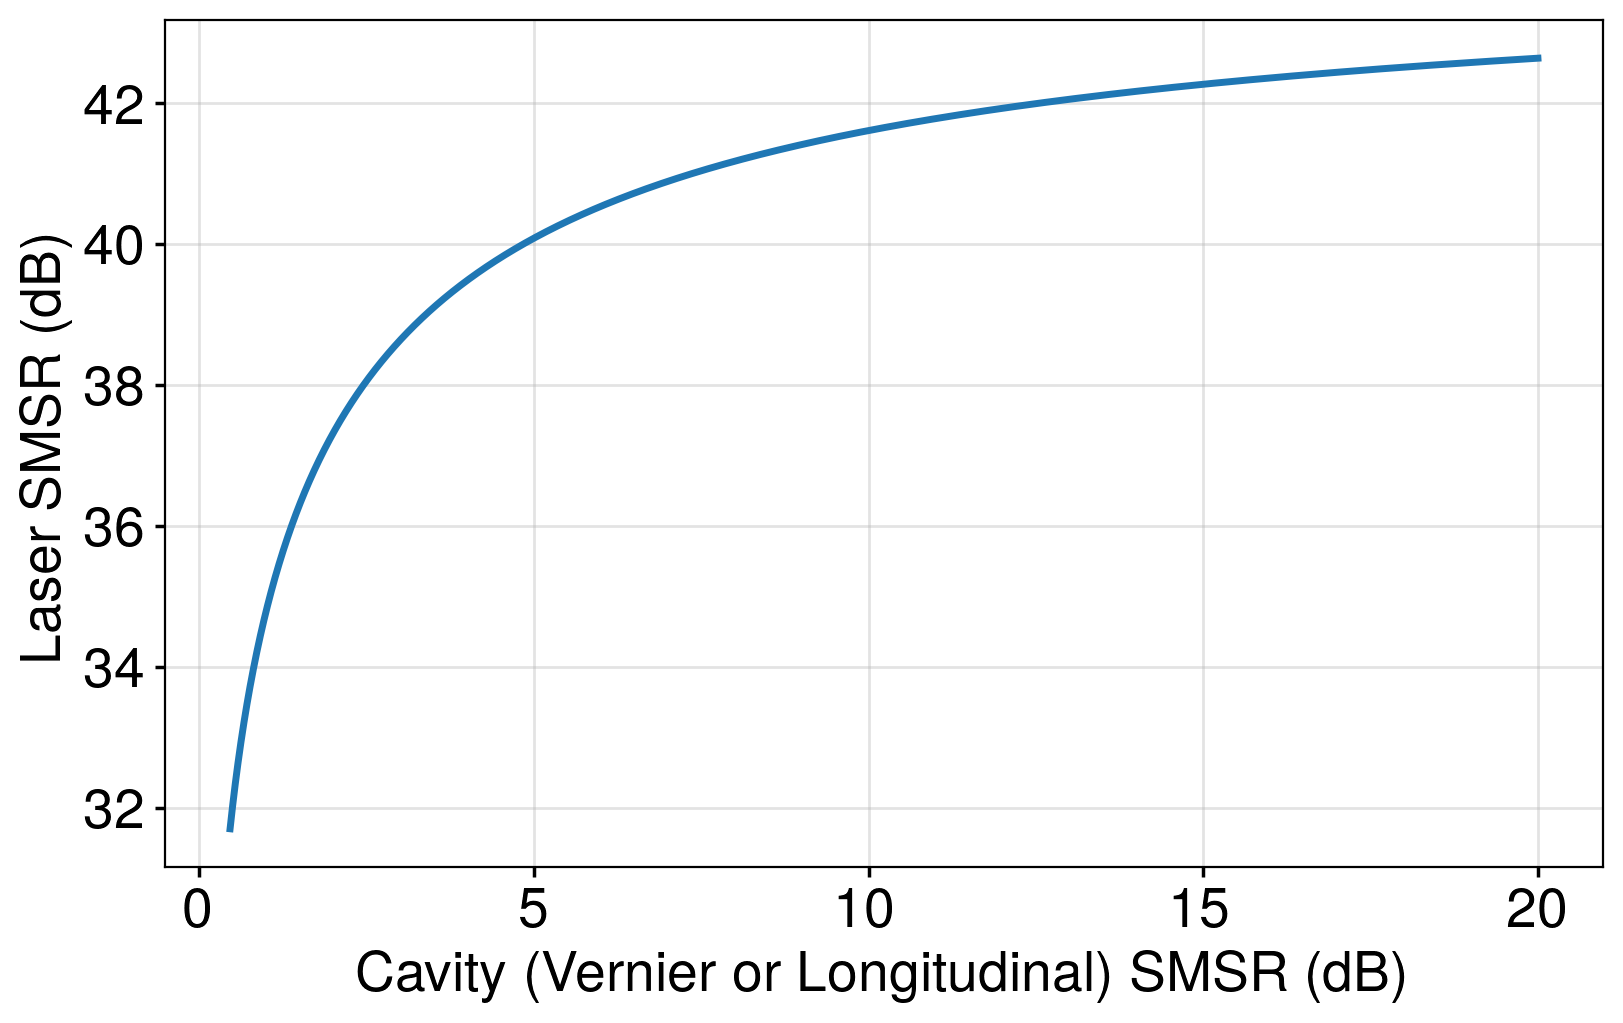

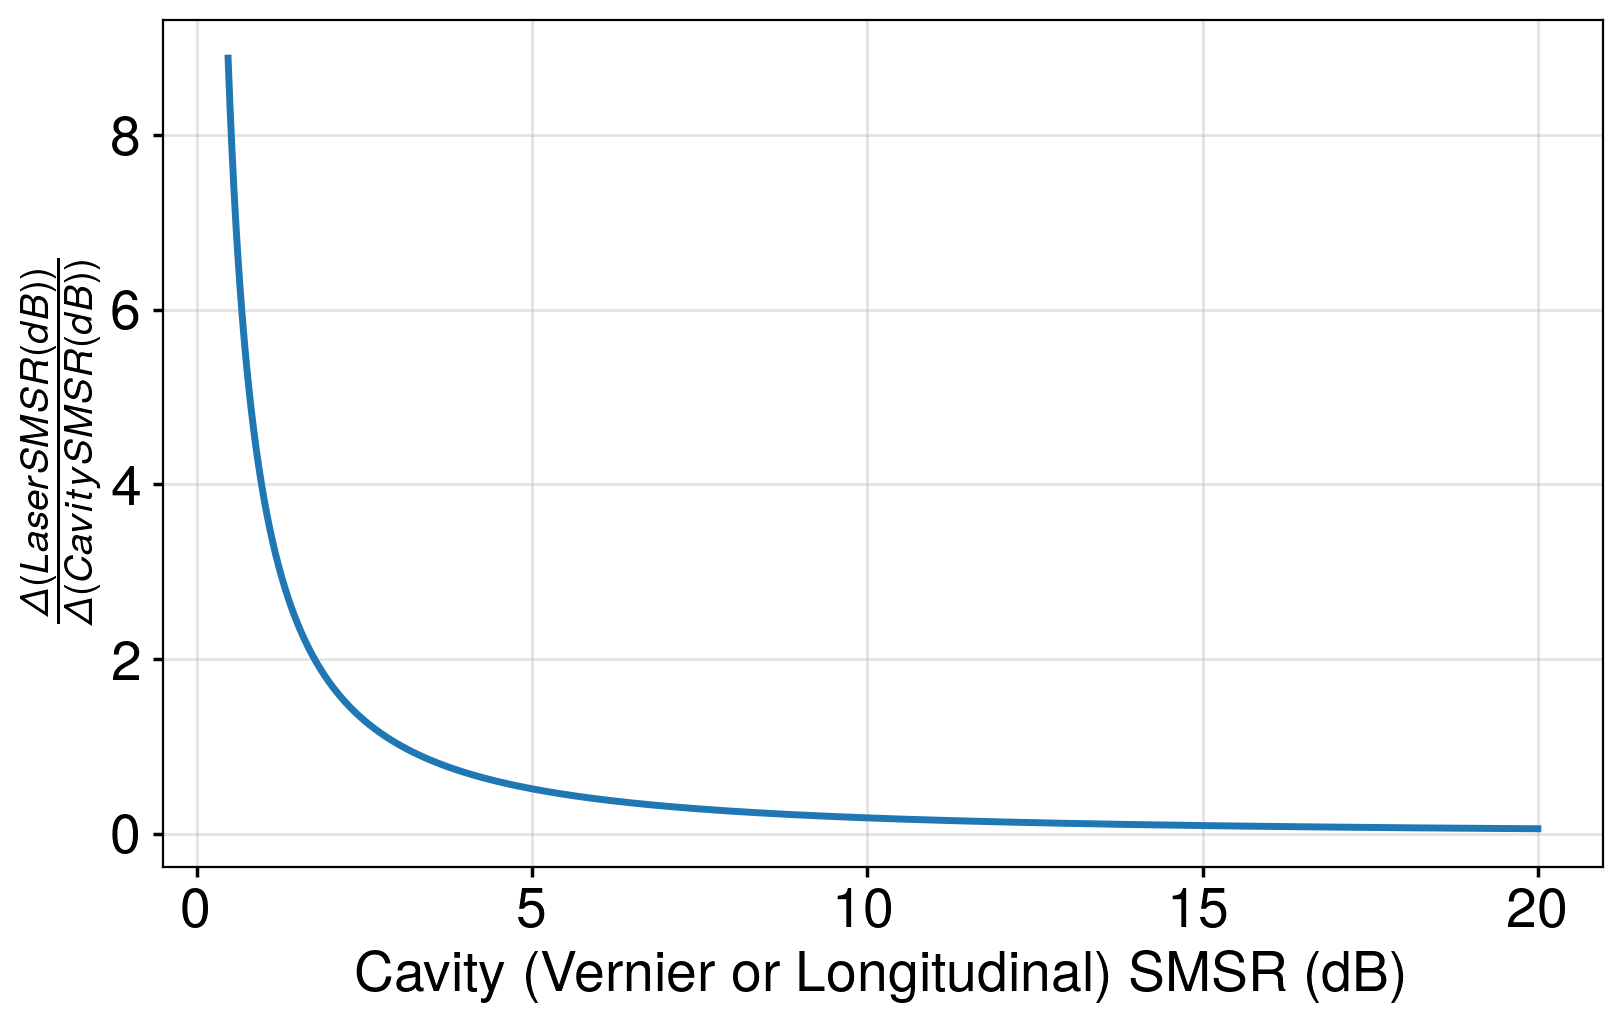

3.0570668852505283


In [54]:
beta_SP = 1e-4
eta_R = 0.8
alphai = 760 #1/m
Lsoa = 1100e-6
Iratio = 3

cavity_attenuation = np.linspace(0.01,0.9,num=1000)
cavity_SMSR_dB = 10*np.log10(1/cavity_attenuation)
deltaalpha = np.array([-1/(2*Lsoa) * np.log(i) for i in cavity_attenuation])


deltaG = beta_SP*eta_R * (alphai + deltaalpha)/(Iratio -1)
Laser_SMSR = deltaalpha/deltaG + 1
Laser_SMSR_dB = 10*np.log10(Laser_SMSR)
plt.figure()
plt.plot(cavity_SMSR_dB,Laser_SMSR_dB)
plt.xlabel("Cavity (Vernier or Longitudinal) SMSR (dB)")
plt.ylabel("Laser SMSR (dB)")
plt.show()

derivative_ratio = np.diff(Laser_SMSR_dB)/np.diff(cavity_SMSR_dB)
plt.figure()
plt.plot(cavity_SMSR_dB[:-1],derivative_ratio)
plt.xlabel("Cavity (Vernier or Longitudinal) SMSR (dB)")
plt.ylabel(r"$\frac{\Delta (Laser SMSR (dB))}{\Delta (Cavity SMSR (dB))}$")
plt.show()

target = 1
print(cavity_SMSR_dB[np.argmin(np.abs(derivative_ratio - target))])

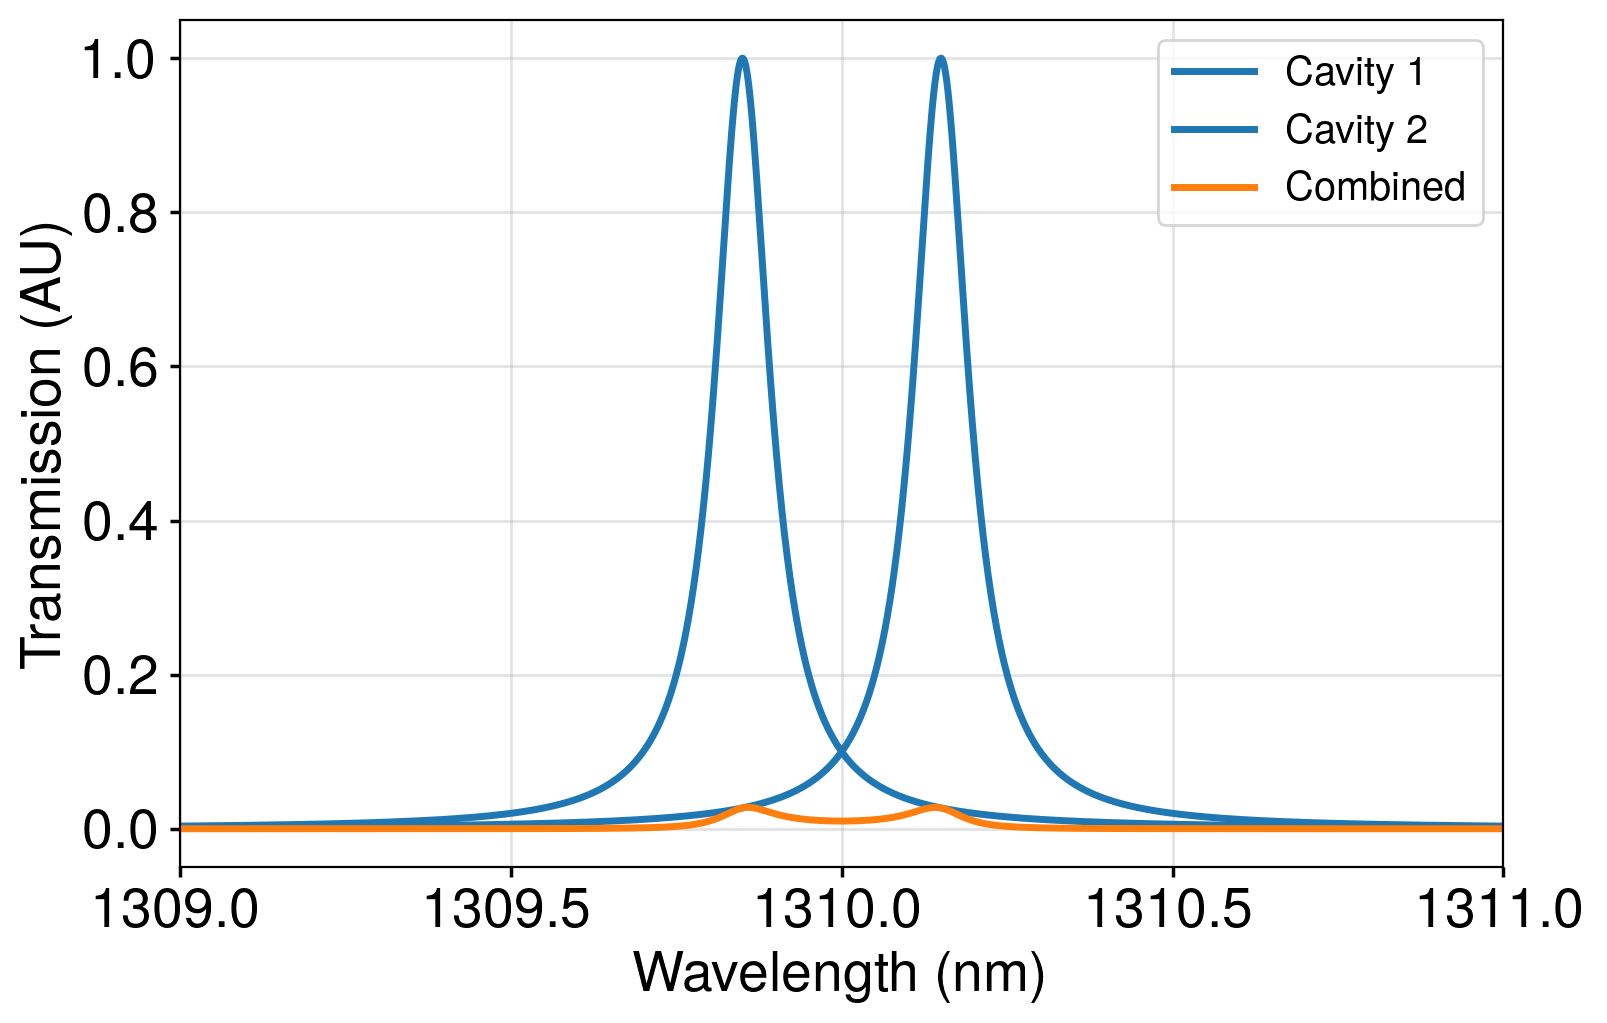

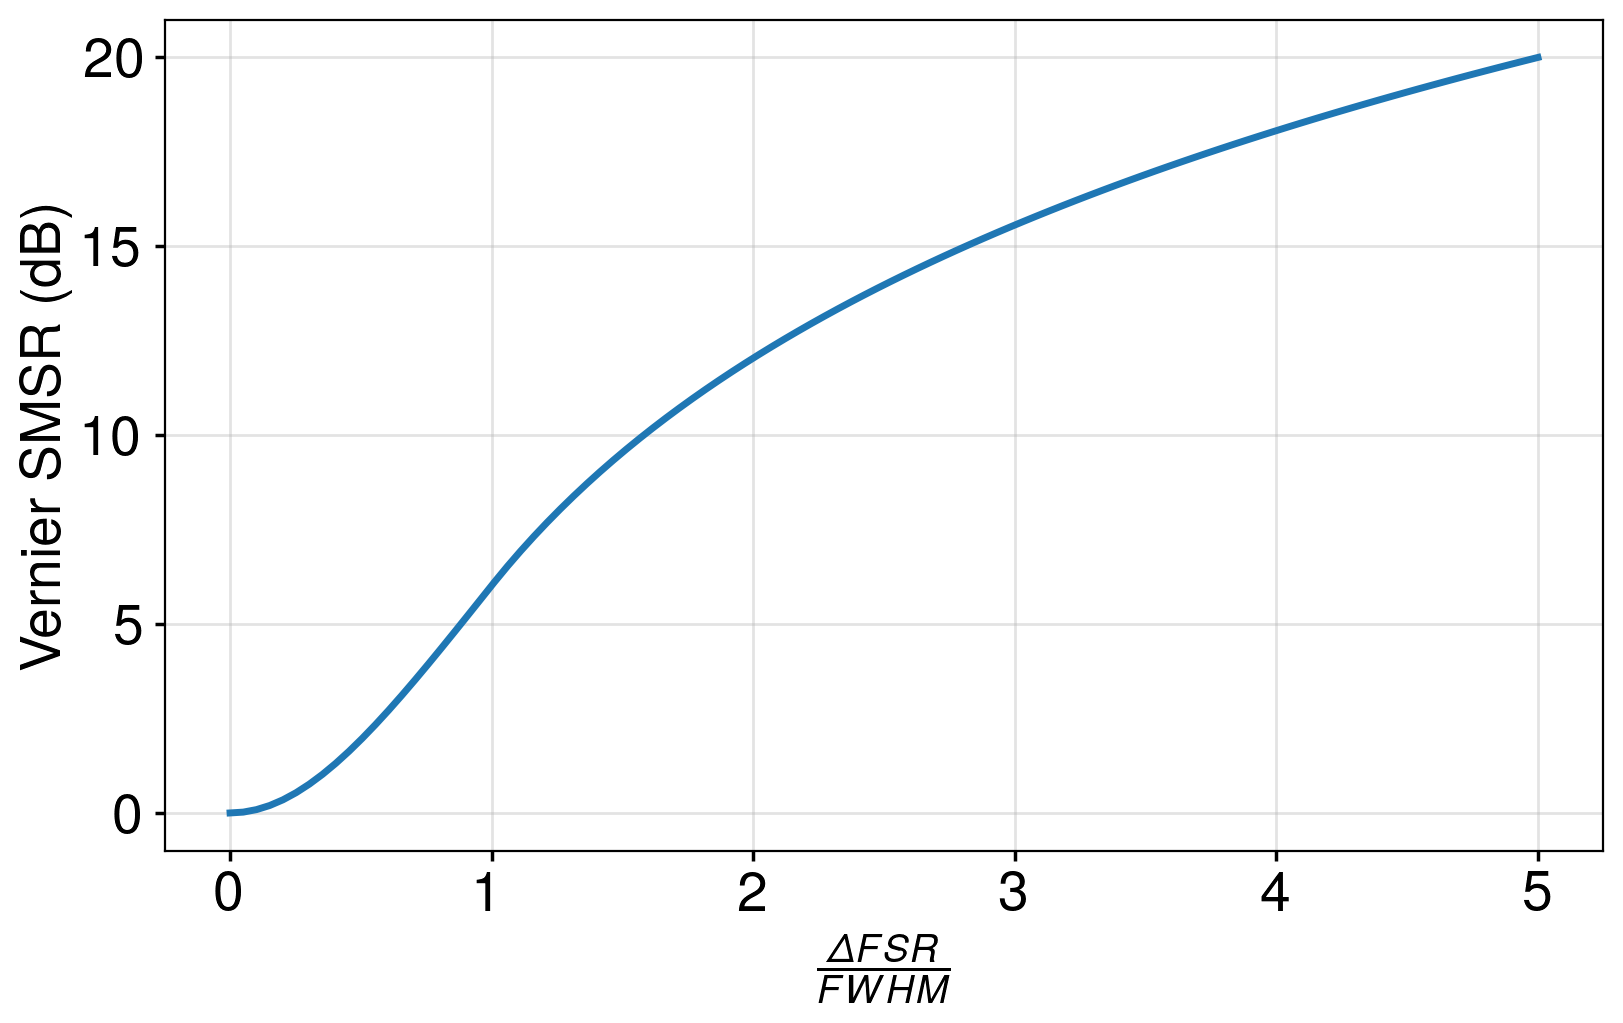

0.6565656565656566


In [59]:
vernier_wav = np.linspace(1308e-9,1312e-9,num=10000)

def lorentzian(Lambda,Lambda_res,FWHM):
    # return 1/((Lambda - Lambda_res)**2/FWHM**2 + 1)
    return FWHM**2/(4*(Lambda - Lambda_res)**2 + (FWHM)**2)

FWHM = 100e-12
delta = 300e-12
cavity1 = np.array([lorentzian(i,Lambda_res=1310e-9-delta/2,FWHM=FWHM) for i in vernier_wav])
cavity2 = np.array([lorentzian(i,Lambda_res=1310e-9+delta/2,FWHM=FWHM) for i in vernier_wav])

combined_response = cavity1 * cavity2
plt.figure()
plt.plot(vernier_wav*1e9,cavity1,c='C0')
plt.plot(vernier_wav*1e9,cavity2,c='C0')
plt.plot(vernier_wav*1e9,combined_response,c='C1')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission (AU)")
plt.legend(['Cavity 1',"Cavity 2", "Combined"])
plt.xlim(1309,1311)
plt.show()

vernier_SMSR_storage = []
fraction_of_a_linewidth_detuned = np.linspace(0,5,num=100)
for i in fraction_of_a_linewidth_detuned:
    FWHM = 100e-12
    delta = i*FWHM/2
    cavity1 = np.array([lorentzian(i,Lambda_res=1310e-9-delta,FWHM=FWHM) for i in vernier_wav])
    cavity2 = np.array([lorentzian(i,Lambda_res=1310e-9+delta,FWHM=FWHM) for i in vernier_wav])

    combined_response = cavity1 * cavity2


    vernier_SMSR_storage.append(1./np.max(combined_response))

vernier_SMSR_storage = np.array(vernier_SMSR_storage)
vernier_SMSR_dB = 10*np.log10(vernier_SMSR_storage)
plt.figure()
plt.plot(fraction_of_a_linewidth_detuned,vernier_SMSR_dB)
plt.xlabel(r"$\frac{\Delta FSR}{FWHM}$")
plt.ylabel("Vernier SMSR (dB)")
plt.show()

target_vernier_SMSR = 3
print(fraction_of_a_linewidth_detuned[np.argmin(np.abs(vernier_SMSR_dB - target_vernier_SMSR))])

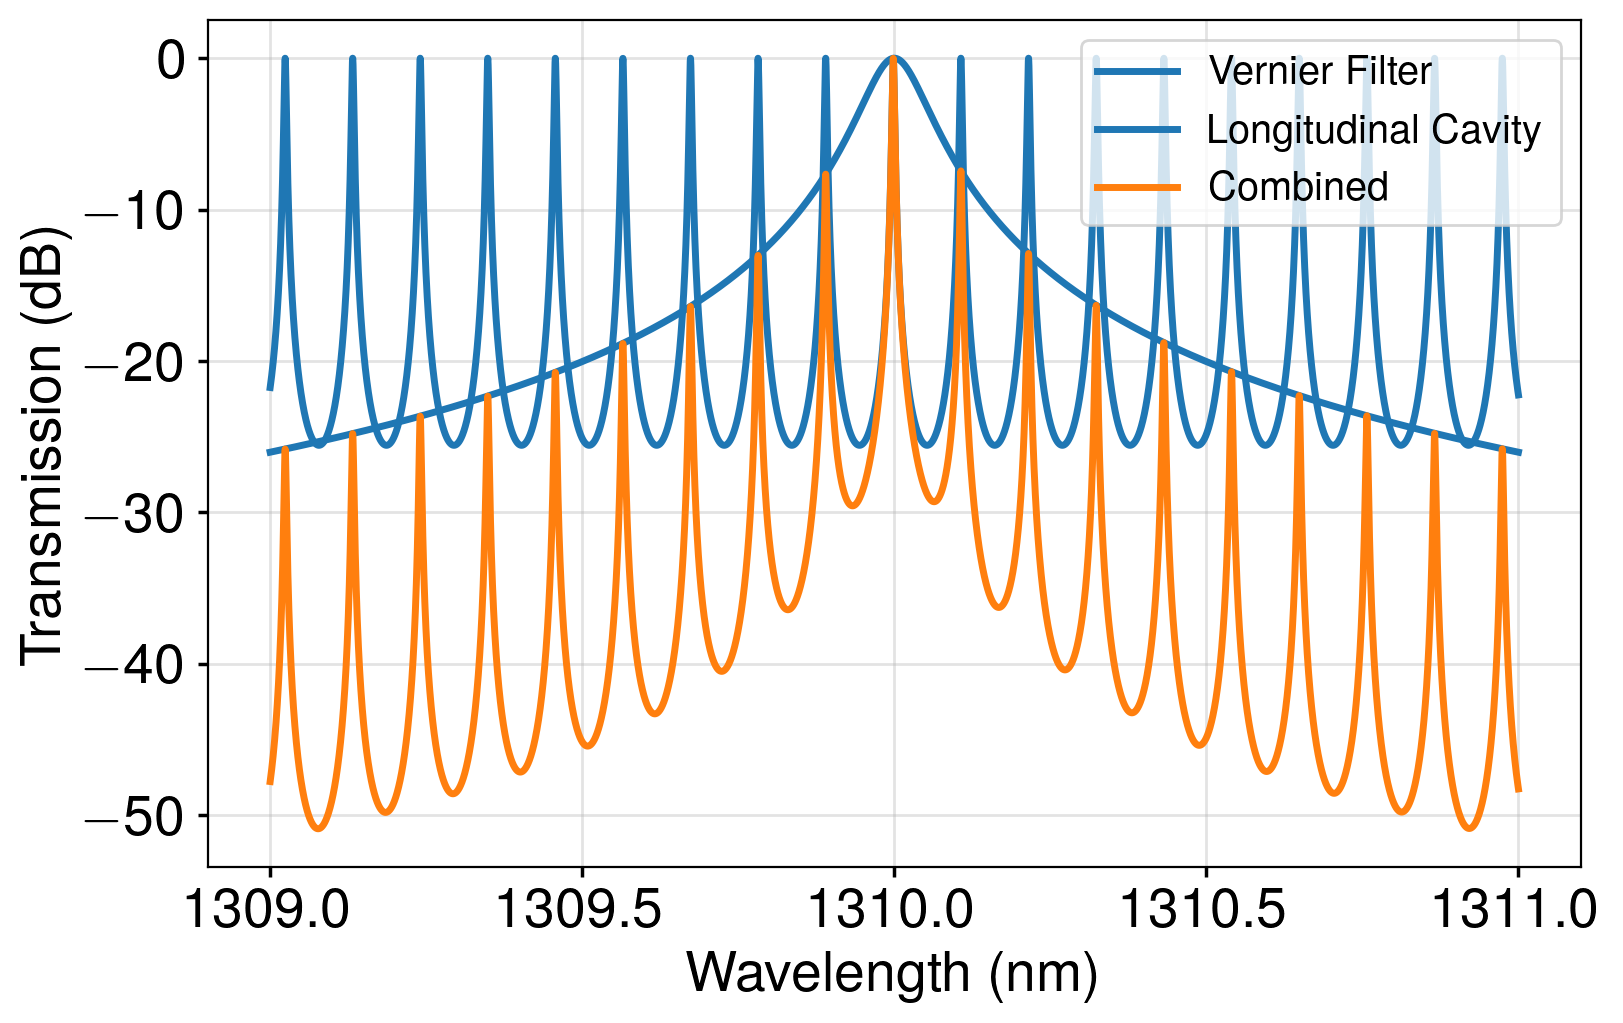

0.32103210321292863


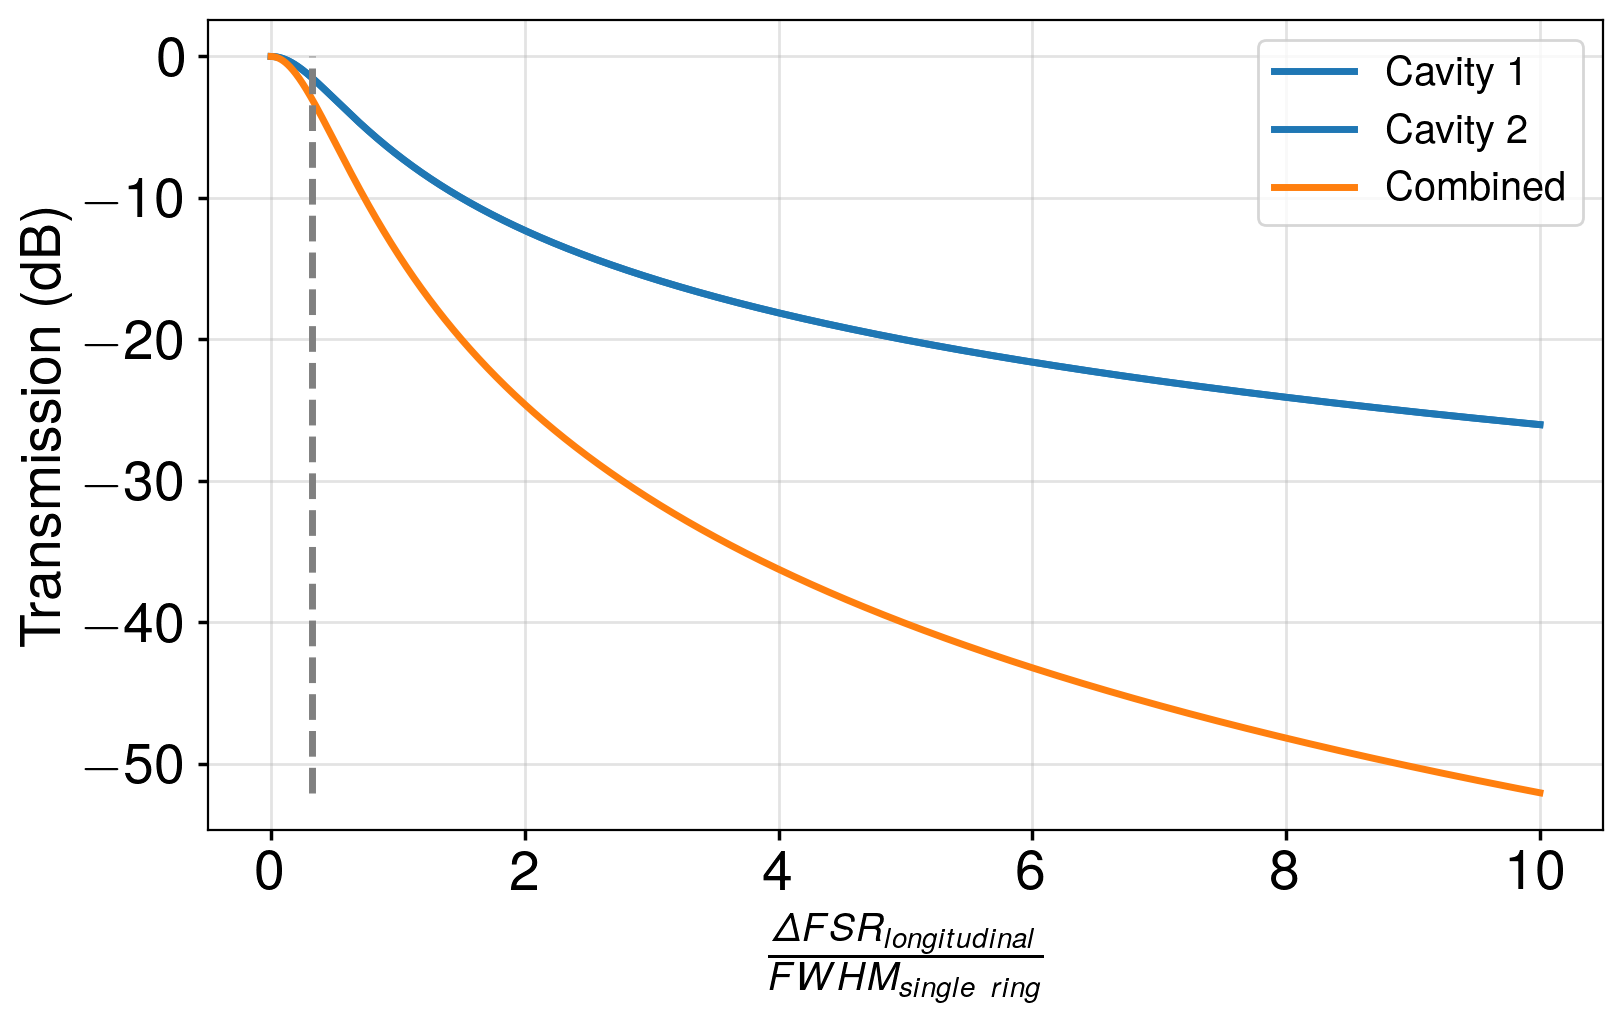

In [62]:
def longitudinal_cavity_transmission(Lambda,L,n=1.98,phi_offset = 0):
    # return 1/(1 + 4*R/(1-R)**2 * np.sin(2*np.pi/Lambda * n * L))
    R1 = 0.9
    R2 = 0.9
    T1 = 1 - R1
    T2 = 1 - R2
    num = np.sqrt(T1*T2) *  np.exp(-1j * (2 * np.pi / Lambda * n * L + phi_offset))
    denom = 1 - np.sqrt(R1*R2) * np.exp(-2 * 1j * (2 * np.pi / Lambda * n * L + phi_offset))
    H = num/denom
    return np.real(H * np.conj(H))

vernier_wav = np.linspace(1309e-9,1311e-9,num=10000)

cavity1 = np.array([lorentzian(i,Lambda_res=1310e-9,FWHM=FWHM) for i in vernier_wav])
long_cavity = np.array([longitudinal_cavity_transmission(Lambda=i,L=4e-3,phi_offset=1.2) for i in vernier_wav])
FSR_long_cavity = 450e-12/5

combined_response = cavity1 * long_cavity
plt.figure()
plt.plot(vernier_wav*1e9,10*np.log10(cavity1),c='C0')
plt.plot(vernier_wav*1e9,10*np.log10(long_cavity),c='C0')
plt.plot(vernier_wav*1e9,10*np.log10(combined_response),c='C1')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission (dB)")
plt.legend(['Vernier Filter',"Longitudinal Cavity", "Combined"])
plt.show()


# Longitudinal cavity design
vernier_wav = np.linspace(1310e-9,1311e-9,num=10000)

FWHM = 100e-12
cavity1 = np.array([lorentzian(i,Lambda_res=1310e-9,FWHM=FWHM) for i in vernier_wav])
cavity2 = np.array([lorentzian(i,Lambda_res=1310e-9,FWHM=FWHM) for i in vernier_wav])

combined_response = cavity1 * cavity2
ideal_value = -3
ideal_point = np.argmin(np.abs(10*np.log10(combined_response) - ideal_value))
delta_FSR_over_FWHM = vernier_wav/FWHM - 1310e-9/FWHM

print(delta_FSR_over_FWHM[ideal_point])

plt.figure()
plt.plot(delta_FSR_over_FWHM,10*np.log10(cavity1),c='C0')
plt.plot(delta_FSR_over_FWHM,10*np.log10(cavity2),c='C0')
plt.plot(delta_FSR_over_FWHM,10*np.log10(combined_response),c='C1')
plt.vlines(delta_FSR_over_FWHM[ideal_point],ymin=np.min(10*np.log10(combined_response)),ymax=np.max(10*np.log10(combined_response)),color='grey',linestyle='--')
plt.xlabel(r"$\frac{\Delta FSR_{longitudinal}}{FWHM_{single \ ring}}$")
plt.ylabel("Transmission (dB)")
plt.legend(['Cavity 1',"Cavity 2", "Combined"])
# plt.xlim(1309,1311)
plt.show()